<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PRA
</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA: Trabajoi Final Deep Learning

En esta práctica se implementará diferentes redes neuronales convolucionales para detectar el glaucoma.

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

# Autor: Mario Ubierna San Mamés

# Presentación

El objetivo de esta práctica es aplicar los conocimientos adquiridos durante toda la asignatura en un caso clínico real. Para ello se dispondrá de una base de datos que contiene imágenes de ojos sanos y de otros afectados por glaucoma. 

El glaucoma es una patología que afecta al nervio óptico y cuyos orígenes son diversos, es la segunda causa de ceguera por detrás de la diabetes y los efectos en la pérdida de visión son irreversibles. Las causas que lo producen se pueden tratar si la patología es detectada
a tiempo.

El objetivo final de esta práctica es, mediante los conocimientos adquiridos, proponer y entrenar un algoritmo que sea capaz de detectar adecuadamente ojos con glaucoma frente a otros sanos.

# Definición del problema

Los algoritmos de reconocimiento de imágenes se están implementando en la práctica clínica, integrándose en ocasiones directamente en el hardware que se utiliza para la  exploración (por ejemplo, en los ecógrafos). Este tipo de aproximación es lo que se propone en el siguiente artículo científico, el cual se utilizará como base para realizar esta práctica:

*   Diaz-Pinto, A., Morales, S., Naranjo, V. et al. CNNs for automatic glaucoma
assessment using fundus images: an extensive validation. BioMed Eng OnLine
18, 29 (2019). https://doi.org/10.1186/s12938-019-0649-y

En esta práctica se dispone de una serie de imágenes de casos reales. El objetivo es obtener un modelo eficaz para detectar de manera temprana esta patología, reduciendo, por lo tanto, el riesgo de ceguera.

La base de datos está formada por imágenes en color de 224x224 píxeles y se ha
dividido en 10 particiones distintas que se usarán para aplicar un método de cross validation con el objetivo de minimizar errores estadísticos. Cada una de estas particiones, a su vez, contiene tres subconjuntos: train, test y valid. Las imágenes a su vez están etiquetadas de dos formas: normal o abnormal.




# Librerías

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import _pickle as pickle
from timeit import default_timer as timer

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn import metrics

from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import layers
from keras.models import load_model
import keras.backend as K

import matplotlib.pyplot as plt

# Carga de Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Sección 1 - Análisis exploratorio de los datos

En este apartado se va a realizar diferentes análisis sobre los datos, así se conseguirá entender mejor la problemática que se busca resolver e idearemos un desarrollo para cumplir el objetivo del proyecto.

Pero antes de comenzar con eso hay que realizar la lectura de los datos:

## Lectura de los datos

In [3]:
# Método que carga una porción específica de los datos, según el fold y el tipo de dataset que queremos cargar
def load_dataset(fold="Fold0", dataset="train"):
  root = "/content/drive/MyDrive/practica_DL_UOC_2022/"

  # Cargamos los datos
  df = pd.DataFrame()
  lstFilenames = []
  lstImages = []
  lstTarget = []

  # abnormal (1)
  for filename in os.listdir(os.path.join(root, fold, dataset, "abnormal")):
    lstFilenames.append(filename.split(".")[0]) # Sin .jpg
    lstImages.append(np.array(Image.open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/", fold, dataset, "abnormal", filename))))
    lstTarget.append(1)

  # normal (0)
  for filename in os.listdir(os.path.join(root, fold, dataset, "normal")):
    lstFilenames.append(filename.split(".")[0]) # Sin .jpg
    lstImages.append(np.array(Image.open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/", fold, dataset, "normal", filename))))
    lstTarget.append(0)

  # Devolvemos el resultado
  df = pd.DataFrame(data={
    "FileName": lstFilenames,
    "Image": lstImages,
    "Target": lstTarget
    })
  
  return df

In [4]:
# Método encargado de cargar todos los datos para un Fold
def load_data(fold="Fold0"):

  print("\n" + fold)
  
  # Cargamos el conjunto de train
  print("\tCargando el conjunto de train...")
  df_train = load_dataset(fold=fold, dataset="train")

  # Cargamos el conjunto de validación
  print("\tCargando el conjunto de valid...")
  df_valid = load_dataset(fold=fold, dataset="valid")

  # Cargamos el conjunto de test
  print("\tCargando el conjunto de test...")
  df_test = load_dataset(fold=fold, dataset="test")

  return df_train, df_valid, df_test

El siguiente paso es guardar los dataframes generados para así no tener que hacerlo cada vez:

In [5]:
def save_data_to_pickle(fold="Fold0", df_train=None, df_valid=None, df_test=None):
  root = "/content/drive/MyDrive/practica_DL_UOC_2022/"

  print("\tGuardamos los conjuntos a formato pickle...")
  df_train.to_pickle(os.path.join(root, fold, "df_train.pickle"))
  df_valid.to_pickle(os.path.join(root, fold, "df_valid.pickle"))
  df_test.to_pickle(os.path.join(root, fold, "df_test.pickle"))

Realizamos la lectura dejamos programada la lectura de los ficheros pickle

In [6]:
def load_data_from_pickle(fold="Fold0"):
  root = "/content/drive/MyDrive/practica_DL_UOC_2022/"

  df_train = pd.read_pickle(os.path.join(root, fold, "df_train.pickle"))
  df_valid = pd.read_pickle(os.path.join(root, fold, "df_valid.pickle"))
  df_test = pd.read_pickle(os.path.join(root, fold, "df_test.pickle"))

  return df_train, df_valid, df_test

In [ ]:
# df_train, df_valid, df_test = load_data_from_pickle(fold="Fold0")

Lo siguiente es hacer la lectura de todos los folds:

In [ ]:
FOLDS = 10

for nFold in range(FOLDS):
  # Obtenemos los datos en un dataframe
  df_train, df_valid, df_test = load_data(fold="Fold" + str(nFold))
  # Guardamos los datos a formato pickle
  save_data_to_pickle(fold="Fold" + str(nFold), df_train=df_train, df_valid=df_valid, df_test=df_test)


Fold0
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold1
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold2
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold3
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold4
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold5
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargando el conjunto de test...
	Guardamos los conjuntos a formato pickle...

Fold6
	Cargando el conjunto de train...
	Cargando el conjunto de valid...
	Cargan

Ahora hay que comprobar que todos los datos estén bien, es decir, que en cada conjunto estén las imágenes correspondientes y que el valor Target sea el que tiene que ser:

In [ ]:
# Método que se encarga de comprobar si la lectura está bien
def check_data(fold="Fold0", dataset="train", df=None):
  root = "/content/drive/MyDrive/practica_DL_UOC_2022/"

  lstFilenames = df["FileName"].values

  # abnormal (1)
  for filename in os.listdir(os.path.join(root, fold, dataset, "abnormal")):

    filename = filename.split(".")[0] 
    # Comprobamos que está la imagen
    if not filename in lstFilenames:
      return False
    # Comprobamos que el target es el adecuado
    if df[df["FileName"] == filename]["Target"].item() != 1:
      return False

  # normal (0)
  for filename in os.listdir(os.path.join(root, fold, dataset, "normal")):

    filename = filename.split(".")[0] 
    # Comprobamos que está la imagen
    if not filename in lstFilenames:
      return False
    # Comprobamos que el target es el adecuado
    if df[df["FileName"] == filename]["Target"].item() != 0:
      return False
  
  return True

In [ ]:
for nFold in range(FOLDS):
  # Comprobamos la data para cada FOLD
  print("Fold" + str(nFold))
  print("\tLeemos los conjuntos de formato pickle...")
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))

  bTrain = check_data(fold="Fold" + str(nFold), dataset="train", df=df_train)
  print("\tTrain: " + str(bTrain))

  bValid = check_data(fold="Fold" + str(nFold), dataset="valid", df=df_valid)
  print("\tValid: " + str(bValid))

  bTest = check_data(fold="Fold" + str(nFold), dataset="test", df=df_test)
  print("\tTest: " + str(bTest))

Fold0
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold1
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold2
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold3
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold4
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold5
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold6
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold7
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold8
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True
Fold9
	Leemos los conjuntos de formato pickle...
	Train: True
	Valid: True
	Test: True


## Análisis

Lo primero de todo es cargar todos los datos para cada uno de los folds, necearios para realizar la práctica:

In [7]:
# Fold0
print("Fold0")
print("\tLeemos los conjuntos de formato pickle...")
f0_df_train, f0_df_valid, f0_df_test = load_data_from_pickle(fold="Fold0")

# Fold1
print("Fold1")
print("\tLeemos los conjuntos de formato pickle...")
f1_df_train, f1_df_valid, f1_df_test = load_data_from_pickle(fold="Fold1")

# Fold2
print("Fold2")
print("\tLeemos los conjuntos de formato pickle...")
f2_df_train, f2_df_valid, f2_df_test = load_data_from_pickle(fold="Fold2")

# Fold3
print("Fold3")
print("\tLeemos los conjuntos de formato pickle...")
f3_df_train, f3_df_valid, f3_df_test = load_data_from_pickle(fold="Fold3")

# Fold4
print("Fold4")
print("\tLeemos los conjuntos de formato pickle...")
f4_df_train, f4_df_valid, f4_df_test = load_data_from_pickle(fold="Fold4")

# Fold5
print("Fold5")
print("\tLeemos los conjuntos de formato pickle...")
f5_df_train, f5_df_valid, f5_df_test = load_data_from_pickle(fold="Fold5")

# Fold6
print("Fold6")
print("\tLeemos los conjuntos de formato pickle...")
f6_df_train, f6_df_valid, f6_df_test = load_data_from_pickle(fold="Fold6")

# Fold7
print("Fold7")
print("\tLeemos los conjuntos de formato pickle...")
f7_df_train, f7_df_valid, f7_df_test = load_data_from_pickle(fold="Fold7")

# Fold8
print("Fold8")
print("\tLeemos los conjuntos de formato pickle...")
f8_df_train, f8_df_valid, f8_df_test = load_data_from_pickle(fold="Fold8")

# Fold9
print("Fold9")
print("\tLeemos los conjuntos de formato pickle...")
f9_df_train, f9_df_valid, f9_df_test = load_data_from_pickle(fold="Fold9")



Fold0
	Leemos los conjuntos de formato pickle...
Fold1
	Leemos los conjuntos de formato pickle...
Fold2
	Leemos los conjuntos de formato pickle...
Fold3
	Leemos los conjuntos de formato pickle...
Fold4
	Leemos los conjuntos de formato pickle...
Fold5
	Leemos los conjuntos de formato pickle...
Fold6
	Leemos los conjuntos de formato pickle...
Fold7
	Leemos los conjuntos de formato pickle...
Fold8
	Leemos los conjuntos de formato pickle...
Fold9
	Leemos los conjuntos de formato pickle...


Una vez cargada toda la información, pasamos a comprobar el número de registros que hay para train, valid y test en cada fold:

In [ ]:
for nFold in range(FOLDS):
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))
  print("Fold" + str(nFold) + ":" + "\ttrain(" + str(len(df_train)) + ")" + "\tvalid(" + str(len(df_valid)) + ")" + "\ttest(" + str(len(df_test)) + ")")


Fold0:	train(1379)	valid(154)	test(174)
Fold1:	train(1379)	valid(154)	test(174)
Fold2:	train(1379)	valid(154)	test(174)
Fold3:	train(1379)	valid(154)	test(174)
Fold4:	train(1379)	valid(154)	test(174)
Fold5:	train(1379)	valid(154)	test(174)
Fold6:	train(1379)	valid(154)	test(174)
Fold7:	train(1379)	valid(154)	test(174)
Fold8:	train(1379)	valid(154)	test(174)
Fold9:	train(1379)	valid(154)	test(174)


Como podemos apreciar en la anterior ejecución, todos los folds contienen el mismo número de imágenes tanto para train como para valid y test.

El siguiente punto es comprobar si hay duplicados (imágenes) en cada conjunto, la representación viene de la forma (x) siendo x el número de duplicados en el conjunto:


In [ ]:
for nFold in range(FOLDS):
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))
  print("Fold" + str(nFold) + ":" + 
        "\ttrain(" + str(len(df_train[df_train.duplicated(["FileName"])])) + ")" +
        "\tvalid(" + str(len(df_valid[df_valid.duplicated(["FileName"])])) + ")" +
        "\ttest(" + str(len(df_test[df_test.duplicated(["FileName"])])) + ")") 

Fold0:	train(0)	valid(0)	test(0)
Fold1:	train(0)	valid(0)	test(0)
Fold2:	train(0)	valid(0)	test(0)
Fold3:	train(0)	valid(0)	test(0)
Fold4:	train(0)	valid(0)	test(0)
Fold5:	train(0)	valid(0)	test(0)
Fold6:	train(0)	valid(0)	test(0)
Fold7:	train(0)	valid(0)	test(0)
Fold8:	train(0)	valid(0)	test(0)
Fold9:	train(0)	valid(0)	test(0)


Tal y como podemos apreciar, no hay duplicados en ningún conjuto de ningún fold. Por lo que, no se procede a la eliminación de los mismos.

Posteriormente, comprobamos si hay duplicados no dentro de cada conjunto sino que dentro de cada fold, la representación es (x) siendo x el número de duplicados por fold:

In [ ]:
for nFold in range(FOLDS):
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))
  lstFilenames = [*df_train["FileName"].values, *df_valid["FileName"].values, *df_test["FileName"].values]
  print("Fold" + str(nFold) + ":" + 
        "\tduplicados(" +  str(len(np.unique(lstFilenames)) - (len(df_train) + len(df_valid) + len(df_test))) + ")"
        ) 

Fold0:	duplicados(0)
Fold1:	duplicados(0)
Fold2:	duplicados(0)
Fold3:	duplicados(0)
Fold4:	duplicados(0)
Fold5:	duplicados(0)
Fold6:	duplicados(0)
Fold7:	duplicados(0)
Fold8:	duplicados(0)
Fold9:	duplicados(0)


Tampoco hay duplicados por fold. Por lo tanto, tampoco se procede a la eliminación de los mismos.

Lo siguiente que vamos a comprobar es el número de casos normal y abnormal que hay en cada conjunto de cada fold, la representación viene de la forma (x,y) siendo x los casos normal e y los abnormal: 

In [ ]:
for nFold in range(FOLDS):
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))
  print("Fold" + str(nFold) + ":" + 
        "\ttrain(N:" + str(np.count_nonzero(df_train["Target"].values == 0)) + ", A:" + str(np.count_nonzero(df_train["Target"].values == 1)) +")" +
        "\tvalid(N:" + str(np.count_nonzero(df_valid["Target"].values == 0)) + ", A:" + str(np.count_nonzero(df_valid["Target"].values == 1)) +")" +
        "\ttest(N:" + str(np.count_nonzero(df_test["Target"].values == 0)) + ", A:" + str(np.count_nonzero(df_test["Target"].values == 1)) +")")

Fold0:	train(N:754, A:625)	valid(N:83, A:71)	test(N:82, A:92)
Fold1:	train(N:740, A:639)	valid(N:88, A:66)	test(N:91, A:83)
Fold2:	train(N:739, A:640)	valid(N:83, A:71)	test(N:97, A:77)
Fold3:	train(N:743, A:636)	valid(N:85, A:69)	test(N:91, A:83)
Fold4:	train(N:746, A:633)	valid(N:81, A:73)	test(N:92, A:82)
Fold5:	train(N:758, A:621)	valid(N:71, A:83)	test(N:90, A:84)
Fold6:	train(N:754, A:625)	valid(N:84, A:70)	test(N:81, A:93)
Fold7:	train(N:737, A:642)	valid(N:82, A:72)	test(N:100, A:74)
Fold8:	train(N:748, A:631)	valid(N:80, A:74)	test(N:91, A:83)
Fold9:	train(N:733, A:646)	valid(N:82, A:72)	test(N:104, A:70)


Como podemos apreciar no hay el mismo número de casos en ningún conjunto para cada fold.

Por lo que vamos a comprobar el número de casos normales y abnormal por fold, independientemente del conjunto que sea, la representación sigue siendo igual (x,y), x son los casos normal e y los abnormal:

In [ ]:
for nFold in range(FOLDS):
  df_train, df_valid, df_test = load_data_from_pickle(fold="Fold" + str(nFold))
  nNormal = np.count_nonzero(df_train["Target"].values == 0) + np.count_nonzero(df_valid["Target"].values == 0) + np.count_nonzero(df_test["Target"].values == 0)
  nAbnormal = np.count_nonzero(df_train["Target"].values == 1) + np.count_nonzero(df_valid["Target"].values == 1) + np.count_nonzero(df_test["Target"].values == 1)
  print("Fold" + str(nFold) + ":" + 
        "\tcases(N:" + str(nNormal) + ", A:" + str(nAbnormal) + ")"
        ) 

Fold0:	cases(N:919, A:788)
Fold1:	cases(N:919, A:788)
Fold2:	cases(N:919, A:788)
Fold3:	cases(N:919, A:788)
Fold4:	cases(N:919, A:788)
Fold5:	cases(N:919, A:788)
Fold6:	cases(N:919, A:788)
Fold7:	cases(N:919, A:788)
Fold8:	cases(N:919, A:788)
Fold9:	cases(N:919, A:788)


Tal y como podemos observar todos los folds tienen el mismo número de casos.

Con esto finalizamos este punto, destacar que en el informe se incluirán gráficas hechas con [Infogram](https://infogram.com/). Básicamente, porque una vez tenemos los datos que nos interesa es más fácil crear las gráficas y que tengan un aspecto elegante. Estas gráficas se pueden visualizar en el informe entregado con la práctica.

# Sección 2 - Entrenamiento de la red sobre Fold0

En esta primera parte se hará un entrenamiento únicamente sobre el fold0. Esto nos permitirá obtener conclusiones preliminares en un plazo razonable de tiempo, antes de ejecutar un entrenamiento completo empleando cross validation (ver sección 3). Para ello se deben proponer y comparar 5 aproximaciones distintas:

* Las 3 primeras configuraciones se deben implementar en un modelo basado en EfficientNet B0, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de GlobalAveragePolling2D, una capa de BatchNormalization, una capa de dropout con probabilidad del 20%, y finalmente una capa fully connected:

  * En la primera configuración se entrena el modelo congelando todas las capas menos las que se han añadido al final (modelo 1).

  * En una segunda configuración, a partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de BatchNorm congeladas (modelo 2).

  * En la tercera configuración, a partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad (modelo 3).

* Entrenar dos configuraciones, modelos o arquitecturas adicionales, que se pueden escoger libremente (modelo 4 y modelo 5).






## Modelo 1 - Modelo base congelado entero

### Creación de los vectores labales y features

Creamos los vectores de labers y feautres para todos los conjuntos de Fold0

In [ ]:
# Train
X_train = np.array(f0_df_train.iloc[:, 1].to_list())
y_train = np.array(f0_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f0_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f0_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f0_df_test.iloc[:, 1].to_list())
y_test = np.array(f0_df_test.iloc[:, 2].to_list())

### Construcción del modelo

La primero que vamos a hacer es definir el método encargado de generar el modelo base (modelo 1), sobre el que se van a basar todos los modelos. Cabe destacar que probamos diferentes optimizadores y learning rates para saber cuál se comporta mejor.

Antes de continuar con la creación del modelo definimos el método encargado de obtener el f1-score, usado como métrica en la contrucción del modelo:

In [8]:
# https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
# Método original que se encuentra en el código original de Keras
def get_f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [9]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
def build_base_model(optimizer="adam", learning_rate=1e-3):
  opt = None # Optimizer
  inputs = layers.Input(shape=(224, 224, 3))
  model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = keras.Model(inputs, outputs, name="EfficientNet")
  if optimizer == "adam":
    opt = Adam(learning_rate=learning_rate)
  elif optimizer == "sgd":
    opt = SGD(learning_rate=learning_rate)

  model.compile(
      optimizer=opt, loss="binary_crossentropy", metrics=[get_f1]
  )

  return model

### Búsqueda de los hiperparámetros

In [ ]:
# Definición de los hiperparámetros
optimizers = ["adam", "sgd"]
learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1]
epochs = 50

In [ ]:
def gridSearch(optimizers, learning_rates, epochs, type_model="base"):
  # Definimos las listas
  training_f1 = []
  validating_f1 = []
  training_times = []

  # Realizamos el computo de cada módelo
  for opt in optimizers:
    for lr in learning_rates:
      start = timer()

      if type_model == "base":
        model_gridsearch_clas = build_base_model(optimizer=opt, learning_rate=lr)

      elif type_model == "partial":
        model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model1/model_EP69_OPsgd_LR0.001.pickle", custom_objects={"get_f1": get_f1})
        model_gridsearch_clas = unfreeze_model(model=model_base,
                                               optimizer=opt, 
                                               learning_rate=lr,
                                               type_model=type_model)
        
      elif type_model == "total":
        model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model2/model_EP12_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})
        model_gridsearch_clas = unfreeze_model(model=model_base,
                                               optimizer=opt, 
                                               learning_rate=lr,
                                               type_model=type_model)

      estimator_gridsearch_clas = model_gridsearch_clas.fit(
          X_train,
          y_train,
          validation_data=(X_valid, y_valid),
          epochs = epochs,
          batch_size=64,
          verbose=0
      )
      end = timer()

      # Añadimos el tiempo de entrenamiento
      training_times.append(round(end-start, 5))

      # Añadimos las precisiones obtenidas
      training_f1.append(estimator_gridsearch_clas.history['get_f1'])
      validating_f1.append(estimator_gridsearch_clas.history['val_get_f1'])

  # Devolvemos los resultado
  return training_times, training_f1, validating_f1

In [ ]:
training_times, training_f1, validating_f1 = gridSearch(optimizers=optimizers, 
                                                        learning_rates=learning_rates, 
                                                        epochs=epochs,
                                                        type_model="base")

Visualizamos el tiempo de entrenamiento para cada modelo, el f1_score obtenido en cada entrenamiento y el f1_score de validación:

In [ ]:
# Definimos la leyenda para los gráficos
legend = [
          "adam-0.0001",
          "adam-0.001",
          "adam-0.01",
          "adam-0.05",
          "adam-0.1",
          "sgd-0.0001",
          "sgd-0.001",
          "sgd-0.01",
          "sgd-0.05",
          "sgd-0.1"
]

In [10]:
def get_plots(legend, training_times, training_f1, validating_f1, type_model="base"):
  # Visualizamos el tiempo de entrenamiento alcanzado por cada velocidad de aprendizaje
  fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
  plt.bar(legend, training_times)
  if type_model == "base": plt.ylim(90, 96)
  if type_model == "partial": plt.ylim(155, 163)
  if type_model == "total": plt.ylim(330, 343)
  plt.xticks(rotation="40")
  plt.title("training time vs learning rate")
  plt.ylabel("time (s)")
  plt.xlabel("learning rate")
  plt.show()

  # Visualizamos la evolución de la accuracy
  fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
  for hist in training_f1:
    plt.plot(hist)
  plt.title('f1-score (training) vs learning rate')
  plt.ylabel('f1-score')
  plt.xlabel('epoch')
  plt.legend(legend, loc='lower right')
  plt.show()

  # # Visualizamos la evolución de la accuracy en test
  fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
  for hist in validating_f1:
    plt.plot(hist)
  plt.title('f1-score (validating) vs learning rate')
  plt.ylabel('f1-score')
  plt.xlabel('epoch')
  plt.legend(legend, loc='lower right')
  plt.show()

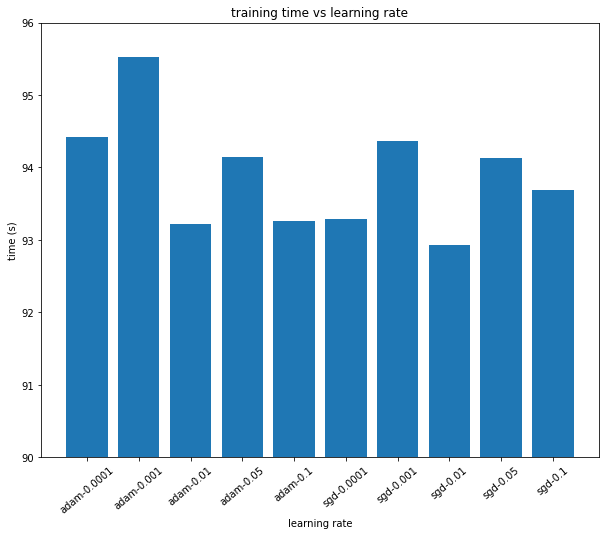

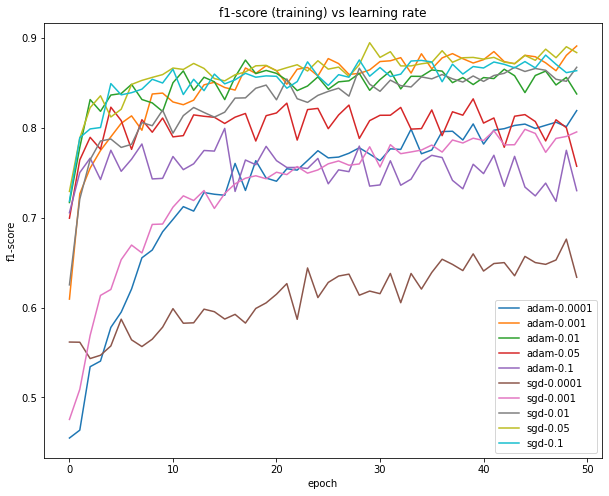

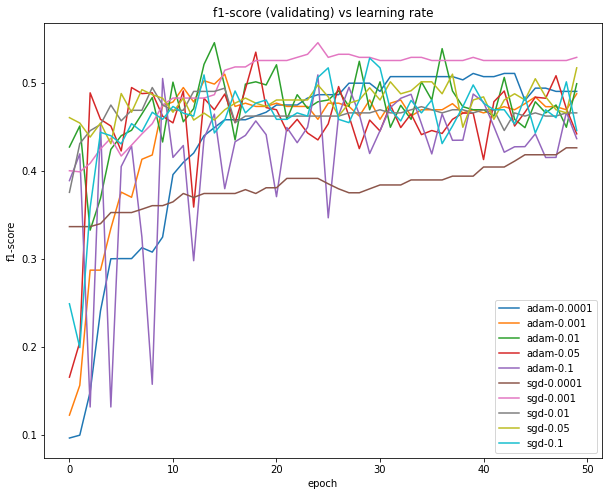

In [ ]:
get_plots(legend=legend,
          training_times=training_times,
          training_f1=training_f1,
          validating_f1=validating_f1)

### Elección mejor modelo

A la vista de los anteriores resultados, podemos apreciar que el modelo que nos proporciona un mayor f1-score presenta las siguientes características:

* Optimizador: SGD.
* Learning-rate: 0.001.

Cabe destacar que este modelo es de los que menos tiempo tarda en entrenarse, además de ser el 4º modelo que menos sobreajusta los datos de entrenamiento, es decir, se consigue el mayor f1-score sobre el conjunto de validación y no se sobreajusta demasiado los datos de entrenamiento.

Por todo lo anterior, se ha utilizado estos parámetros para elegir el modelo final.

Como a priori se desconoce el número de época ideal se va a hacer uso de `EarlyStopping`, se monitoriza la pérdida en validación buscando que sea mínima, si no mejora dicha pérdida en 3 épocas se para el entrenamiento alcanzando la época que sea.

Cabe mencionar que el número total de épocas es 100, es decir, si sigue mejorando el entrenamiento de la red se parará en la época 100.

Definimos el `EarlyStopping` para el modelo 1:

In [ ]:
early_stopping_model1 = EarlyStopping(monitor="val_loss", mode="min", patience=3)

Entrenamos la red:

In [ ]:
model1 = build_base_model(optimizer="sgd", learning_rate=1e-3)
history_model1 = model1.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model1]
)

Epoch 1/100
22/22 [==============================] - 10s 181ms/step - loss: 0.8856 - get_f1: 0.4831 - val_loss: 0.7363 - val_get_f1: 0.3314
Epoch 2/100
22/22 [==============================] - 3s 115ms/step - loss: 0.7666 - get_f1: 0.5475 - val_loss: 0.7050 - val_get_f1: 0.3370
Epoch 3/100
22/22 [==============================] - 3s 115ms/step - loss: 0.7007 - get_f1: 0.5853 - val_loss: 0.6804 - val_get_f1: 0.3233
Epoch 4/100
22/22 [==============================] - 3s 115ms/step - loss: 0.6771 - get_f1: 0.6089 - val_loss: 0.6589 - val_get_f1: 0.3355
Epoch 5/100
22/22 [==============================] - 3s 115ms/step - loss: 0.6373 - get_f1: 0.6349 - val_loss: 0.6397 - val_get_f1: 0.3736
Epoch 6/100
22/22 [==============================] - 3s 116ms/step - loss: 0.6112 - get_f1: 0.6533 - val_loss: 0.6228 - val_get_f1: 0.3895
Epoch 7/100
22/22 [==============================] - 3s 115ms/step - loss: 0.5979 - get_f1: 0.6666 - val_loss: 0.6066 - val_get_f1: 0.3789
Epoch 8/100
22/22 [=======

### Guardado del modelo

Antes de evaluar el modelo 1 final vamos a realizar el guardado del mismo:

In [ ]:
MODEL_NAME = "model1/"
EPOCHS = 69
OPTIMIZER = "sgd"
LEARNING_RATE = 1e-3

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
model1.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model1/model_EP69_OPsgd_LR0.001.pickle/assets


In [ ]:
# Guardamos el history del modelo
pickle.dump(history_model1.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

Al final de este punto se van a discutir los resultados obtenidos, pero antes vamos a visualizar diferentes datos para evaluar el modelo:

* Matriz de confusión.
* Informe de clasificación.
* Curva ROC y su AUC.

In [ ]:
y_probs = model1.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

Métodos para graficar la matriz de confusión y la curva ROC junto el AUC:

In [11]:
def plot_confusion_matrix(y_true, y_pred):
  # Matriz de confusion
  matrix = confusion_matrix(y_true, y_pred)

  # Visualización de la matriz de confusión
  # https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
  sns.heatmap(matrix, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(list(np.unique(y_pred)))
  ax.yaxis.set_ticklabels(list(np.unique(y_pred)))
  plt.show()

def plot_ROC_AUC(y_true, y_prob):
  fpr, tpr, _ = roc_curve(y_true, y_prob)
  fig, ax1 = plt.subplots(1,1, figsize = (8, 8))
  ax1.plot(fpr, tpr, 'b.-', label = 'AUC:%2.3f' % roc_auc_score(y_test, y_probs))
  ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
  ax1.legend(loc = 4)
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate');
  ax1.set_title('ROC Curve')

Los resultados obtenidos son los siguientes:

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.76      0.90      0.83        82
           1       0.90      0.75      0.82        92

    accuracy                           0.82       174
   macro avg       0.83      0.83      0.82       174
weighted avg       0.83      0.82      0.82       174



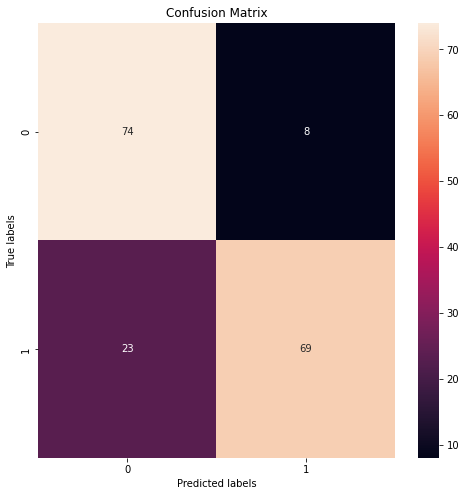

In [ ]:
plot_confusion_matrix(y_test, y_preds)

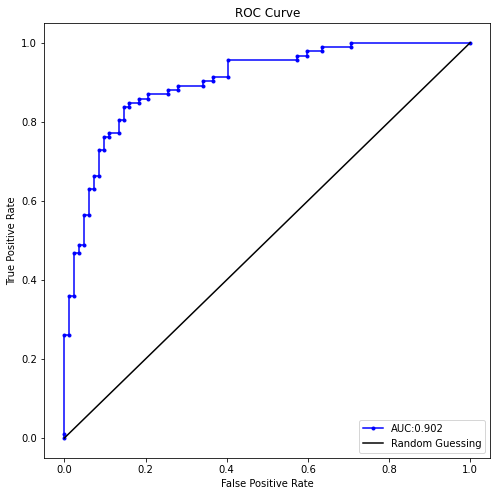

In [ ]:
plot_ROC_AUC(y_test, y_probs)

### Discusión resultados

Tal y como podemos apreciar en al anterior punto, los resultados obtenidos entrenando solamente el clasificador final son buenos.

En cuanto al informe de clasificación, observamos que se consigue una mayor precisión para los casos en los que hay una anomalía, sin embargo, la sensibilidad (recall) es peor cuando se diagnositca dicha enfermedad. El f1-score obtenido para ambas clases está muy bien, lo ideal es que sea a partir del 0.9, pero consiguiendo estos resultados solamente entrenando el clasificador final son muy buenos.

En el ámbito sanitario se busca diagnoticar una enfermedad, en nuestro caso, el glaucoma de la mejor forma posible. Vemos que este modelo es capaz de identificar de forma casi correcta los falsos positivos, es decir, aquellos casos en los que la red devuelve que hay una anomalía pero en la realidad no es así; esto no suele ser un problema, ya que nos permitiría ser más precavidos. Sin embargo, cuando se realiza el diagnóstico de una enfermedad buscamos reducir los falsos negativos, es decir, los casos en los que se predice como que no hay una enfermedad cuando en la realidad sí que es así.

En este modelo los falsos positvos son 8 para el conjunto de test, tal y como podemos ver en la matriz de confusión, frente a los 23 falsos negativos.

Respecto a la curva ROC y su valor AUC (area under curve), vemos que el valor obtenido es elevado (0.902), es decir, el modelo presenta una proporción correcta entre los falsos positivos y los verdaderos positivos.

Como podemos observar este modelo es bueno, pero se van a realizar otros con el objetivo de mejorar los resultados.


## Modelo 2 - descongelación parcial

### Construcción del modelo

La primero que vamos a hacer es definir el método encargado de generar el modelo (modelo 2 y modelo 3). Cabe destacar que probamos diferentes optimizadores y learning rates para saber cuál se comporta mejor.

In [12]:
def unfreeze_model(model, optimizer="adam", learning_rate=1e-3, type_model="partial"):
  opt = None # optimizer

  # Unfreeze last 20 layers
  if type_model == "partial":
    for layer in model.layers[-20:]:
      if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

  elif type_model == "total":
    # Unfreeze all
    for layer in model.layers:
      layer.trainable = True

  # Compile
  if optimizer == "adam":
    opt = Adam(learning_rate=learning_rate)
  elif optimizer == "sgd":
    opt = SGD(learning_rate=learning_rate)

  model.compile(
      optimizer=opt, loss="binary_crossentropy", metrics=[get_f1]
  )

  return model

### Búsqueda de los hiperparámetros

In [ ]:
# Definición de los hiperparámetros
optimizers = ["adam", "sgd"]
learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1]
epochs = 50

In [ ]:
training_times, training_f1, validating_f1 = gridSearch(optimizers=optimizers, 
                                                        learning_rates=learning_rates, 
                                                        epochs=epochs,
                                                        type_model="partial")

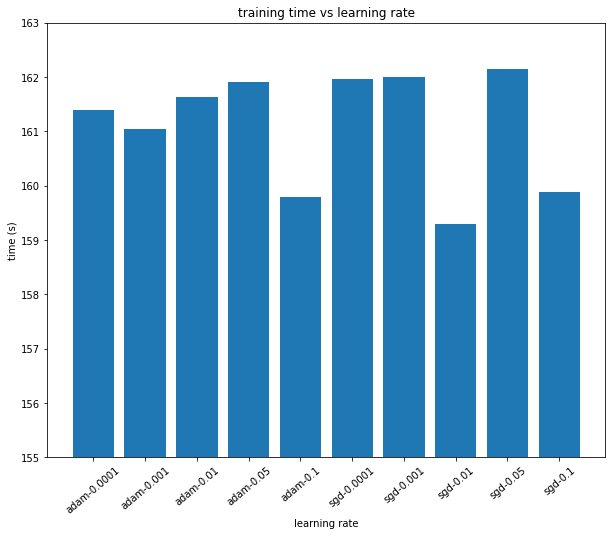

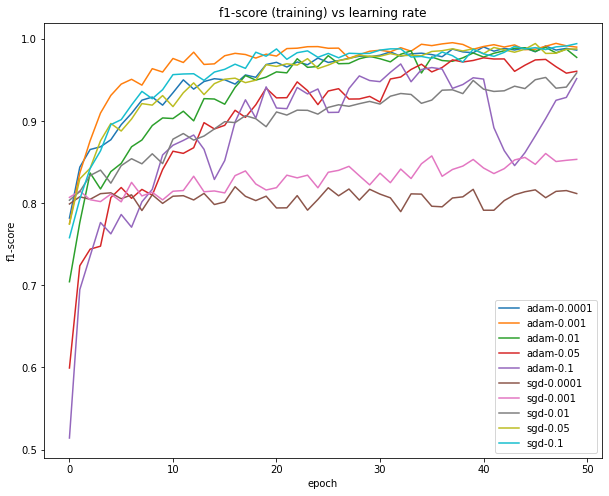

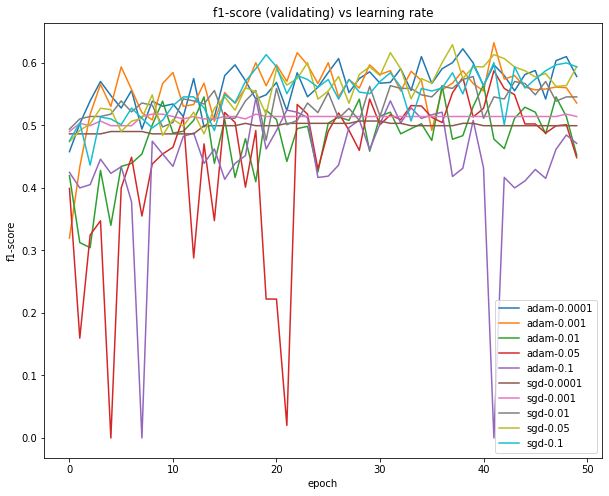

In [ ]:
get_plots(legend=legend,
          training_times=training_times,
          training_f1=training_f1,
          validating_f1=validating_f1,
          type_model="partial")

### Elección mejor modelo

A la vista de los anteriores resultados, podemos apreciar que el modelo que nos proporciona un mayor f1-score presenta las siguientes características:

* Optimizador: ADAM.
* Learning-rate: 0.0001.

Cabe destacar que este modelo es uno de los que más tiempo tarda en entrenarse, pero tiende a sobreajustar menos los datos que otros optimizadores con otros learning rates. Es verdad, que en 50 épocas tanto el SGD-0.1 como el SGD-0.05 son los que más f1-score suelen alcanzar a lo largo de todo el entrenamiento, pero el Adam-0.0001 es el que menos tiende a sobreajustar los datos de estos dos.

Por todo lo anterior, se ha utilizado estos parámetros para elegir el modelo final.

Como a priori se desconoce el número de época ideal se va a hacer uso de `EarlyStopping` al igual que sucedía con el modelo anterior. Se va a monitorizar la pérdida en validación buscando que sea mínima, si no mejora dicha pérdida en 3 épocas se para el entrenamiento alcanzando la época que sea.

Cabe mencionar que el número total de épocas es 100, es decir, si sigue mejorando el entrenamiento de la red se parará en la época 100.

Definimos el `EarlyStopping` para el modelo 2:

In [ ]:
early_stopping_model2 = EarlyStopping(monitor="val_loss", mode="min", patience=3)

Entrenamos la red:

In [ ]:
# Cargamos el modelo 1
model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model1/model_EP69_OPsgd_LR0.001.pickle", custom_objects={"get_f1": get_f1})

# Descongelamos las últimas 20 capas del modelo 1
model2 = unfreeze_model(model=model_base,
                        optimizer="adam",
                        learning_rate=1e-4,
                        type_model="partial")

# Entrenamos el modelo 2
history_model2 = model2.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model2]
)

Epoch 1/100
22/22 [==============================] - 10s 195ms/step - loss: 0.4060 - get_f1: 0.8000 - val_loss: 0.4060 - val_get_f1: 0.5024
Epoch 2/100
22/22 [==============================] - 3s 129ms/step - loss: 0.3438 - get_f1: 0.8203 - val_loss: 0.4005 - val_get_f1: 0.5103
Epoch 3/100
22/22 [==============================] - 3s 129ms/step - loss: 0.3089 - get_f1: 0.8500 - val_loss: 0.3485 - val_get_f1: 0.5288
Epoch 4/100
22/22 [==============================] - 3s 130ms/step - loss: 0.2825 - get_f1: 0.8792 - val_loss: 0.3727 - val_get_f1: 0.4864
Epoch 5/100
22/22 [==============================] - 3s 129ms/step - loss: 0.2693 - get_f1: 0.8695 - val_loss: 0.3746 - val_get_f1: 0.5060
Epoch 6/100
22/22 [==============================] - 3s 130ms/step - loss: 0.2520 - get_f1: 0.8986 - val_loss: 0.3195 - val_get_f1: 0.5211
Epoch 7/100
22/22 [==============================] - 3s 130ms/step - loss: 0.2267 - get_f1: 0.9034 - val_loss: 0.3225 - val_get_f1: 0.5179
Epoch 8/100
22/22 [=======

### Guardado del modelo

Antes de evaluar el modelo 2 final vamos a realizar el guardado del mismo:

In [ ]:
MODEL_NAME = "model2/"
EPOCHS = 12
OPTIMIZER = "adam"
LEARNING_RATE = 1e-4

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
model2.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model2/model_EP12_OPadam_LR0.0001.pickle/assets


In [ ]:
# Guardamos el history del modelo
pickle.dump(history_model2.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

Vamos a visualizar diferentes datos para evaluar el modelo:

* Matriz de confusión.
* Informe de clasificación.
* Curva ROC y su AUC.

In [ ]:
y_probs = model2.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

Los resultados obtenidos son los siguientes:

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83        82
           1       0.94      0.71      0.81        92

    accuracy                           0.82       174
   macro avg       0.84      0.83      0.82       174
weighted avg       0.85      0.82      0.82       174



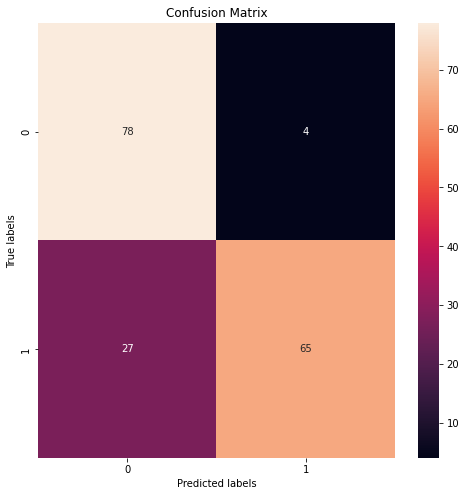

In [ ]:
plot_confusion_matrix(y_test, y_preds)

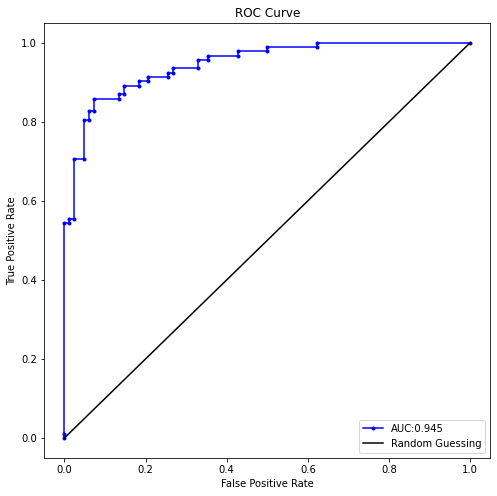

In [ ]:
plot_ROC_AUC(y_test, y_probs)

### Discusión resultados

Tal y como podemos ver en el informe de clasificación, este modelo se comporta de forma parecida al modelo anterior cuando la imagen proporcionada no presenta glaucuma, es decir, es un 0. Sin embargo, a la hora de diagnósticar el glaucoma se consigue una mayor precisión pero un menor recall, es decir, se consigue reducir el número de falsos positivos pero no el de falsos negativos.

Esta apreciación lo podemos  ver también en la matriz de confusión, ahora en la clasificación del conjunto de test tenemos 4 falsos positivos frente a los 8 que había antes, y hay 27 falsos negativos frente a los 23 del modelo anterior.

En el ámbito sanitario se busca reducir los falsos negativos antes que los falsos positivos, por lo que este modelo se comportaría algo peor.

Por otro lado, vemos que el AUC de este modelo es mayor al anterior, ahora es de un 0.945 frente a 0.902, es decir, hay una mejora a la detección de los falsos positivos frente a los verdaderos positivos, tal y como se ha mencionado anteriormente.

En resumen, este modelo a nivel numérico se comporta mejor que el modelo anterior, pero hay que recordar que estamos en el ámbito sanitario, por lo que hay que priorizar los fasos negativos. Es por ello, que este modelo no ha conseguido superar al modelo anterior.

## Modelo 3 - descongelación total

### Búsqueda de los hiperparámetros

In [ ]:
# Definición de los hiperparámetros
optimizers = ["adam", "sgd"]
learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1]
epochs = 25

In [ ]:
training_times, training_f1, validating_f1 = gridSearch(optimizers=optimizers, 
                                                        learning_rates=learning_rates, 
                                                        epochs=epochs,
                                                        type_model="total")

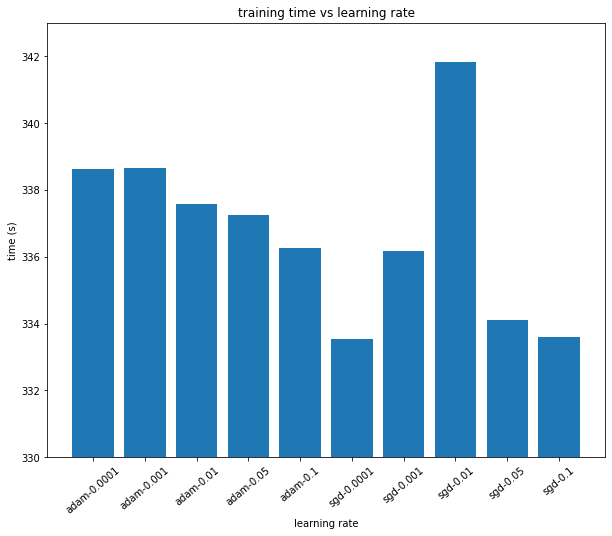

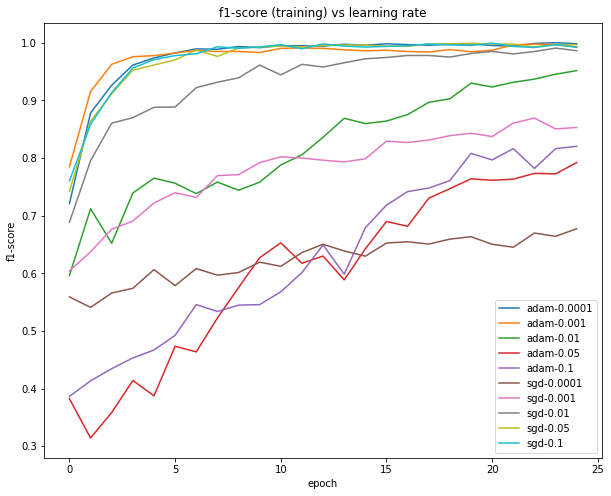

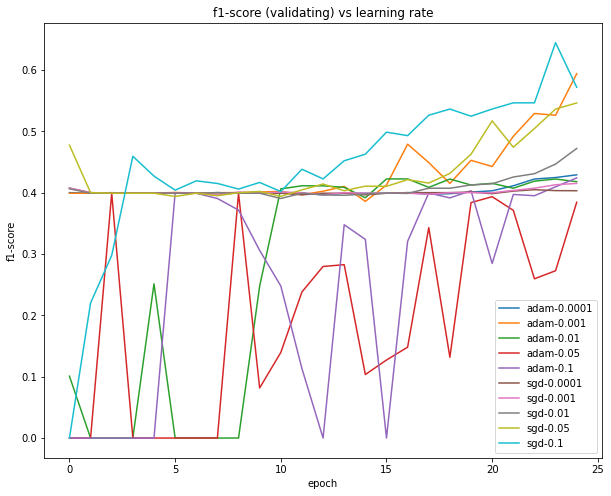

In [ ]:
get_plots(legend=legend,
          training_times=training_times,
          training_f1=training_f1,
          validating_f1=validating_f1,
          type_model="total")

### Elección mejor modelo

A la vista de los anteriores resultados, podemos apreciar que el modelo que nos proporciona un mayor f1-score presenta las siguientes características:

* Optimizador: SGD.
* Learning-rate: 0.1.

Cabe destacar que este modelo es uno de los que menos tiempo tarda en entrenarse, otros modelos como SGD-0.05 o ADAM-0.001 consiguen aumentar el f1-score para el conjunto de validación, pero tardan más en obtener un buen f1-score.

Por todo lo anterior, se ha utilizado estos parámetros para elegir el modelo final.

Definimos el `EarlyStopping` al igual que hemos hecho en todos los modelos. Se va a monitorizar el f1-score para el conjunto de validación buscando que sea máximo, si no mejora dicho score en 5 épocas se para el entrenamiento alcanzando la época que sea. Se aumenta ese límite a 5 ya que si nos fijamos en las anteriores ilustraciones, no es hasta la época 10 en la que hay una mejora en los modelos, si establecemos un `patience = 3` se para el entrenamiento antes de llegar a la época 10.

Cabe mencionar que el número total de épocas es 100, es decir, si sigue mejorando el entrenamiento de la red se parará en la época 100.

Definimos el `EarlyStopping` para el modelo 3:

In [ ]:
early_stopping_model3 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

Entrenamos la red:

In [ ]:
# Cargamos el modelo 2
model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model2/model_EP12_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# Descongelamos todas las capas del modelo 2
model3 = unfreeze_model(model=model_base,
                        optimizer="sgd",
                        learning_rate=0.1,
                        type_model="total")

# Entrenamos el modelo 3
history_model3 = model3.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model3]
)

Epoch 1/100
22/22 [==============================] - 22s 653ms/step - loss: 0.5548 - get_f1: 0.7526 - val_loss: 0.8618 - val_get_f1: 0.2571
Epoch 2/100
22/22 [==============================] - 13s 594ms/step - loss: 0.2964 - get_f1: 0.8622 - val_loss: 0.7483 - val_get_f1: 0.4103
Epoch 3/100
22/22 [==============================] - 13s 594ms/step - loss: 0.2091 - get_f1: 0.9035 - val_loss: 0.8770 - val_get_f1: 0.4112
Epoch 4/100
22/22 [==============================] - 13s 594ms/step - loss: 0.1494 - get_f1: 0.9299 - val_loss: 0.6208 - val_get_f1: 0.4151
Epoch 5/100
22/22 [==============================] - 13s 586ms/step - loss: 0.1006 - get_f1: 0.9583 - val_loss: 0.6799 - val_get_f1: 0.4258
Epoch 6/100
22/22 [==============================] - 13s 582ms/step - loss: 0.0456 - get_f1: 0.9813 - val_loss: 0.6721 - val_get_f1: 0.4212
Epoch 7/100
22/22 [==============================] - 13s 591ms/step - loss: 0.0315 - get_f1: 0.9876 - val_loss: 0.7538 - val_get_f1: 0.4210
Epoch 8/100
22/22 [=

### Guardado del modelo

Antes de evaluar el modelo 3 final vamos a realizar el guardado del mismo:

In [ ]:
MODEL_NAME = "model3/"
EPOCHS = 26
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
model3.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model3/model_EP26_OPsgd_LR0.1.pickle/assets


In [ ]:
# Guardamos el history del modelo
pickle.dump(history_model3.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

Vamos a visualizar diferentes datos para evaluar el modelo:

* Matriz de confusión.
* Informe de clasificación.
* Curva ROC y su AUC.

In [ ]:
y_probs = model3.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

Los resultados obtenidos son los siguientes:

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87        82
           1       0.95      0.78      0.86        92

    accuracy                           0.86       174
   macro avg       0.87      0.87      0.86       174
weighted avg       0.88      0.86      0.86       174



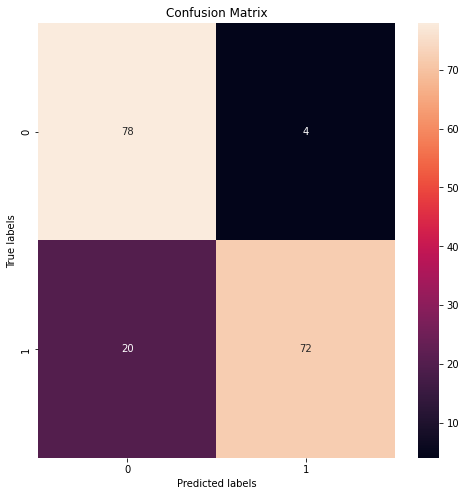

In [ ]:
plot_confusion_matrix(y_test, y_preds)

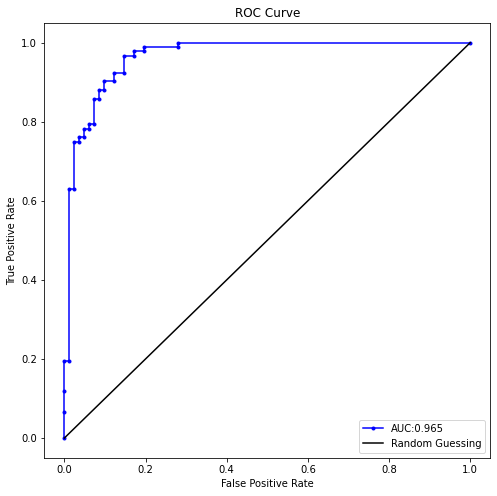

In [ ]:
plot_ROC_AUC(y_test, y_probs)

### Discusión resultados

Visualizando el informe de clasificación podemos apreciar que este modelo es el que mejor se comporta de los tres analaizados, tanto a nivel numérico como teniendo en cuenta que estamos en el ámbito sanitario.

En este caso, se consigue una mayor precisión y un mayor recall para ambas clases, es decir, el f1-score en este caso es mejor que en los modelos anteriores tanto para el caso en el que no hay glaucoma como en el que sí.

Aumentar la precisión nos indica que el modelo es capaz de reducir los falsos positivos, pero también aumenta el recall por lo que se reduce los casos de falsos negativos (importante a tener en cuenta en la salud).

Esta mejora la podemos visualizar en la matriz de confusión:

* Respecto a los falsos positivos, el primer modelo presentaba 8 mientras que el segundo modelo 4. En el tercer modelo se sigue manteniendo a 4.

* Respecto a los falsos negativos, el primer modelo tenía 23 y el segundo 27. En este caso, obtenemos 20. Mejorando significativamente el modelo.

Finalmente, el valor AUC es de 0.965 el más alto alcanzado, haciendose ver que es mejor este modelo identificando los falsos positivos.

En resumen, el tercer modelo ha sido el mejor encontrado hasta el momento.

## Modelo 4 - Aumentos de datos y descongelación parcial

Para la creación de este modelo vamos a cambiar la arquitectura de la red, en este casi se va a añadir una capa para el aumento de datos.

El objetivo de los modelos 4 y 5 es hacer lo mismo que los modelos 2 y 3 realizados anteriormente, es decir, se van a usar los mismos hiperparámetros que en dichos modelos para así comparar sí afecta el aumento de datos al entrenamiento y f1-score, independientemente de los hiperparámetros.

### Construcción del modelo base

Antes de realizar el modelo 4 y 5 debemos "recrear" el modelo 1 con aumento de datos, y realizar los mismos pasos que hicimos en dicho modelo:

In [13]:
# Definimos el layer para el aumento de datos
img_augmentation = Sequential(
    [
     layers.RandomRotation(factor=0.05),
     layers.RandomTranslation(height_factor=0.05, width_factor=0.02),
     layers.RandomFlip("horizontal"),
     layers.RandomContrast(factor=0.05),
    ],
    name = "img_augmentation"
)

In [20]:
# Definimos el método encargado de crear el modelo base de datos aumentados
def build_base_model_data_augmentated(optimizer="adam", learning_rate=1e-3, freeze=True):
  opt = None # Optimizer
  
  inputs = layers.Input(shape=(224, 224, 3))
  x = img_augmentation(inputs)
  model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

  # Freeze the pretrained weights
  if freeze == True:
    model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = keras.Model(inputs, outputs, name="EfficientNet")
  if optimizer == "adam":
    opt = Adam(learning_rate=learning_rate)
  elif optimizer == "sgd":
    opt = SGD(learning_rate=learning_rate)

  model.compile(
      optimizer=opt, loss="binary_crossentropy", metrics=[get_f1]
  )

  return model

### Entrenamiento del modelo base (clasificador final)

Recordando los parámetros que presentasba el modelo base (modelo 1) eran:

* Optimizador: SGD.
* Learning-rate: 0.001.

Sí que vamos a variar el `EarlyStopping` que en el modelo 1, y entrenamos la red:

In [ ]:
early_stopping_model1_1 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [ ]:
model1_1 = build_base_model_data_augmentated(optimizer="sgd", learning_rate=1e-3)
history_model1_1 = model1_1.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model1_1]
)

Epoch 1/100
22/22 [==============================] - 10s 192ms/step - loss: 0.9587 - get_f1: 0.4766 - val_loss: 0.6849 - val_get_f1: 0.2928
Epoch 2/100
22/22 [==============================] - 3s 127ms/step - loss: 0.8616 - get_f1: 0.4953 - val_loss: 0.6717 - val_get_f1: 0.2926
Epoch 3/100
22/22 [==============================] - 3s 127ms/step - loss: 0.8065 - get_f1: 0.5188 - val_loss: 0.6599 - val_get_f1: 0.2929
Epoch 4/100
22/22 [==============================] - 3s 128ms/step - loss: 0.7506 - get_f1: 0.5707 - val_loss: 0.6492 - val_get_f1: 0.3012
Epoch 5/100
22/22 [==============================] - 3s 128ms/step - loss: 0.6846 - get_f1: 0.5948 - val_loss: 0.6386 - val_get_f1: 0.3096
Epoch 6/100
22/22 [==============================] - 3s 129ms/step - loss: 0.6430 - get_f1: 0.6352 - val_loss: 0.6280 - val_get_f1: 0.3596
Epoch 7/100
22/22 [==============================] - 3s 129ms/step - loss: 0.6438 - get_f1: 0.6393 - val_loss: 0.6180 - val_get_f1: 0.3596
Epoch 8/100
22/22 [=======

### Guardado del modelo base

Antes de evaluar el modelo 1 final vamos a realizar el guardado del mismo:

In [ ]:
MODEL_NAME = "model1_1/"
EPOCHS = 23
OPTIMIZER = "sgd"
LEARNING_RATE = 1e-3

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
model1_1.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model1_1/model_EP23_OPsgd_LR0.001.pickle/assets


In [ ]:
# Guardamos el history del modelo
pickle.dump(history_model1_1.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME, "history.pickle"), 'wb'))

### Entrenamiento del modelo 4

Los hiperparámetros son los mismos que usados en el modelo 2:

* Optimizador: ADAM.
* Learning-rate: 0.0001.


In [ ]:
early_stopping_model4 = EarlyStopping(monitor="val_get_f1", mode="max", patience=3)

Entrenamos la red:

In [ ]:
# Cargamos el modelo 1_1
model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model1_1/model_EP23_OPsgd_LR0.001.pickle", custom_objects={"get_f1": get_f1})

# Descongelamos las últimas 20 capas del modelo 1_1
model4 = unfreeze_model(model=model_base,
                        optimizer="adam",
                        learning_rate=1e-4,
                        type_model="partial")

# Entrenamos el modelo 2
history_model4 = model4.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model4]
)

Epoch 1/100
22/22 [==============================] - 11s 204ms/step - loss: 0.4694 - get_f1: 0.7631 - val_loss: 0.5370 - val_get_f1: 0.4262
Epoch 2/100
22/22 [==============================] - 3s 140ms/step - loss: 0.4179 - get_f1: 0.7940 - val_loss: 0.6486 - val_get_f1: 0.4029
Epoch 3/100
22/22 [==============================] - 3s 141ms/step - loss: 0.3559 - get_f1: 0.8269 - val_loss: 0.6506 - val_get_f1: 0.4130
Epoch 4/100
22/22 [==============================] - 3s 141ms/step - loss: 0.3471 - get_f1: 0.8263 - val_loss: 0.5875 - val_get_f1: 0.4274
Epoch 5/100
22/22 [==============================] - 3s 142ms/step - loss: 0.3120 - get_f1: 0.8503 - val_loss: 0.5473 - val_get_f1: 0.4173
Epoch 6/100
22/22 [==============================] - 3s 143ms/step - loss: 0.3107 - get_f1: 0.8461 - val_loss: 0.5649 - val_get_f1: 0.4305
Epoch 7/100
22/22 [==============================] - 3s 143ms/step - loss: 0.2890 - get_f1: 0.8543 - val_loss: 0.5609 - val_get_f1: 0.4364
Epoch 8/100
22/22 [=======

### Guardado del modelo

In [ ]:
MODEL_NAME = "model4/"
EPOCHS = 21
OPTIMIZER = "adam"
LEARNING_RATE = 1e-4

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
model4.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle/assets


In [ ]:
# Guardamos el history del modelo
pickle.dump(history_model4.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

Vamos a visualizar diferentes datos para evaluar el modelo:

* Matriz de confusión.
* Informe de clasificación.
* Curva ROC y su AUC.

In [ ]:
y_probs = model4.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

Los resultados obtenidos son los siguientes:

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85        82
           1       0.95      0.75      0.84        92

    accuracy                           0.84       174
   macro avg       0.86      0.85      0.84       174
weighted avg       0.86      0.84      0.84       174



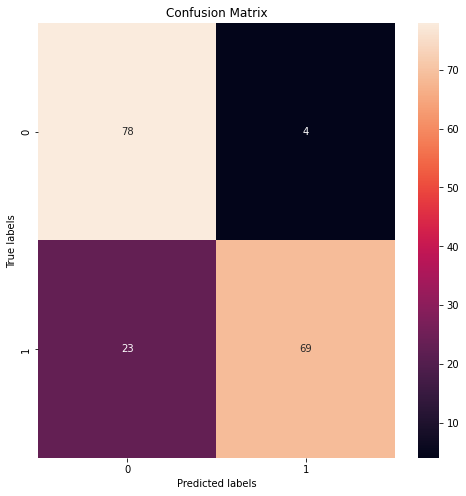

In [ ]:
plot_confusion_matrix(y_test, y_preds)

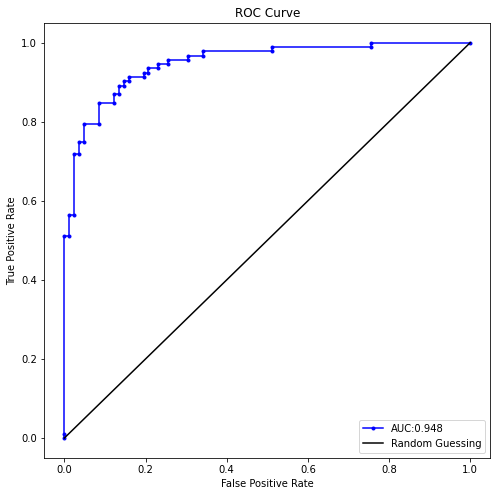

In [ ]:
plot_ROC_AUC(y_test, y_probs)

### Discusión resultados

Comparando el informe de clasificación de este modelo frente al modelo 2 vemos que sí que se produce una mejora al realizar el aumento de datos, cabe recordar que en ambos se hace la misma descongelación (últimas 20 capas) y se usan los mismos hiperparámetros.

En este caso se mejora tanto la precisión como el recall de ambas clases, aumentando así el f1-score obtenido.

Respecto al número de falsos positivos que hay en ambos modelos es el mismo, es decir, 4. Sin embargo, para el modelo 4 se reduce más los falsos negativos, ya que en el modelo 2 hay 27 y ahora 23.

Por otro lado, el valor AUC en este caso es 0.948 algo mayor que en el modelo 2 que era 0.945.

En resumen, este modelo se comporta mejor que el modelo 2, es decir, sí que hay una mejora al realizar el aumento de datos, pero aún así es algo peor que el modleo 3 (en el que se realiza una descongelación total).

## Modelo 5 - Aumento de datos y descongelación total

En este caso, se va a realizar un modelo igual al modelo 3, con la excepción de que se usa aumento de datos. Por lo tanto, los hiperparámetros usados van a ser los mismos que el modelo 3 con el fin de ver si hay una mejora al hacer uso de aumento de datos.

### Entrenamiento del modelo 5

Recordando los parámetros usados:

* Optimizador: SGD.
* Learning-rate: 0.1.

In [ ]:
early_stopping_model5 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [ ]:
# Cargamos el modelo 4
model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# Descongelamos todas las capas del modelo 4
model5 = unfreeze_model(model=model_base,
                        optimizer="sgd",
                        learning_rate=0.1,
                        type_model="total")

# Entrenamos el modelo 5
history_model5 = model5.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model5]
)

Epoch 1/100
22/22 [==============================] - 22s 666ms/step - loss: 0.5374 - get_f1: 0.7447 - val_loss: 0.8442 - val_get_f1: 0.3910
Epoch 2/100
22/22 [==============================] - 13s 605ms/step - loss: 0.3778 - get_f1: 0.8224 - val_loss: 1.4779 - val_get_f1: 0.4010
Epoch 3/100
22/22 [==============================] - 13s 612ms/step - loss: 0.2856 - get_f1: 0.8744 - val_loss: 0.7261 - val_get_f1: 0.3329
Epoch 4/100
22/22 [==============================] - 13s 605ms/step - loss: 0.2403 - get_f1: 0.8906 - val_loss: 0.5391 - val_get_f1: 0.4340
Epoch 5/100
22/22 [==============================] - 13s 600ms/step - loss: 0.1592 - get_f1: 0.9338 - val_loss: 0.5323 - val_get_f1: 0.4776
Epoch 6/100
22/22 [==============================] - 13s 594ms/step - loss: 0.1562 - get_f1: 0.9326 - val_loss: 0.9731 - val_get_f1: 0.4131
Epoch 7/100
22/22 [==============================] - 13s 597ms/step - loss: 0.1209 - get_f1: 0.9477 - val_loss: 0.6303 - val_get_f1: 0.4224
Epoch 8/100
22/22 [=

### Guardado del modelo

Antes de evaluar el modelo 3 final vamos a realizar el guardado del mismo:

In [ ]:
MODEL_NAME = "model5/"
EPOCHS = 32
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
model5.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model5/model_EP32_OPsgd_LR0.1.pickle/assets


In [ ]:
# Guardamos el history del modelo
pickle.dump(history_model5.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

Vamos a visualizar diferentes datos para evaluar el modelo:

* Matriz de confusión.
* Informe de clasificación.
* Curva ROC y su AUC.

In [ ]:
y_probs = model5.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

Los resultados obtenidos son los siguientes:

In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90        82
           1       0.97      0.84      0.90        92

    accuracy                           0.90       174
   macro avg       0.91      0.91      0.90       174
weighted avg       0.91      0.90      0.90       174



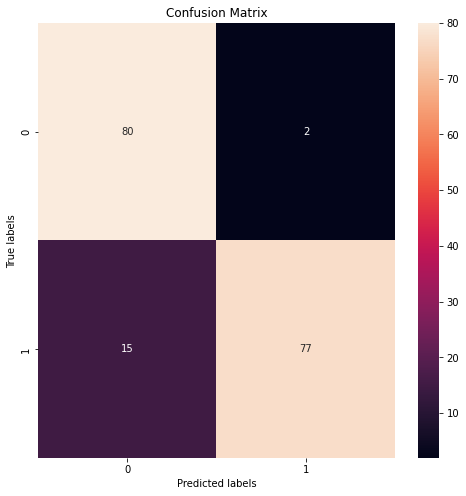

In [ ]:
plot_confusion_matrix(y_test, y_preds)

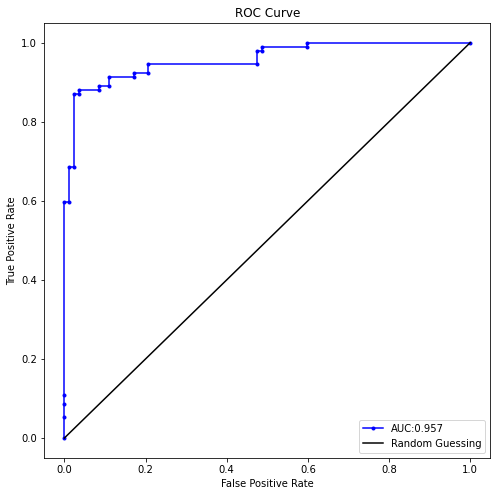

In [ ]:
plot_ROC_AUC(y_test, y_probs)

### Discusión resultados

Si analizamos los resultados obtenidos para este modelo, podemos ver que son los mejores en todos los aspectos.

Observando el informe de clasificación se consigue mejorar la precisión y el recall para ambas clases frente a todos los modelos anteriores, es decir, se consigue reducir tanto los falsos positivos y los falsos negativos.

Si nos fijamos en el f1-score de ambas clases es de 0.90, por lo que el modelo obtenido es muy bueno.

Respecto a la matriz de confusión se ha conseguido reducir los falsos positivos a 2, previamente el mejor resultado fue 4. Y se ha reducido los falsos negativos a 15, anteriormente el mejor resultado fue 20.

En cuanto al valur AUC en este caso es de 0.957, un valor alto acorde a los resultados obtenidos.

En resumen, este modelo es el mejor que hemos obtenido, por lo que llegamos a la conclusión que realizar aumento de datos y descongelar toda la red consigue mejorar los resultados. Es por ello que se usará este modelo para resolver el siguiente ejercicio.

# Sección 3 - Validación cruzada y discusión

El objetivo de la técnica de cross validation es seleccionar qué modelo es más
adecuado, intentando reducir los sesgos y variaciones estadísticas en función de cómo se ha realizado la partición. En los apartados anteriores se ha trabajado con una de las particiones (fold0) y se han estudiado 5 modelos distintos.

En este caso, se debe:

* Aplicar una técnica de cross validation sobre el mejor de los modelos definidos anteriormente. Los datos ya contienen 10 particiones distintas (de fold0 a fold9), por lo que se debe entrenar el modelo escogido sobre los datos de train de cada una de las particiones, evaluarlas, eligiendo en cada caso el mejor modelo de validación.

* Obtener el valor de F1 score de cada partición sobre el conjunto de test. De
esta forma, se obtendrán 10 valores F1 score de test distintos.

* Calcular el valor medio y la desviación estándar.

Caba recordar que el mejor modelo encontrado ha sido el modelo 5, es decir, aquel en el que hacemos un aumento de datos y una descongelación total de la red.

Debido a esto usaremos dicho modelo para cada uno de los folds, eso si entrenando desde 0.

Lo primero de todo es definir la lista para almacenar todos los f1-score obtenidos:

In [15]:
# Definición de la lista que va a almacenar cada uno de los f1-score sobre test para cada fold
lstF1 = []

## Fold0

### Creación de los vectores labales y features

Creamos los vectores de labers y feautres para todos los conjuntos de Fold0

In [16]:
# Train
X_train = np.array(f0_df_train.iloc[:, 1].to_list())
y_train = np.array(f0_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f0_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f0_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f0_df_test.iloc[:, 1].to_list())
y_test = np.array(f0_df_test.iloc[:, 2].to_list())

### Entrenamiento

Recordando los parámetros usados:

* Optimizador: SGD.
* Learning-rate: 0.1.

In [17]:
early_stopping_model_f0 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [22]:
# # Cargamos el modelo 4
# model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# # Descongelamos todas las capas del modelo 4
# modelf0 = unfreeze_model(model=model_base,
#                         optimizer="sgd",
#                         learning_rate=0.1,
#                         type_model="total")

# Creamos el modelo 5 desde 0, aumento de datos con los pesos de imagenet y todas las capas descongeladas
modelf0 = build_base_model_data_augmentated(optimizer="sgd", learning_rate=0.1, freeze=False)

# Entrenamos el modelo final
start = timer()

history_modelf0 = modelf0.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model_f0],
    verbose=0
)

end = timer()

print("El tiempo de entrenamiento es: " + str(round((end - start) / 60, 2)) + " minutos")

El tiempo de entrenamiento es: 3.52 minutos


### Guardado del modelo

In [24]:
MODEL_NAME = "model_cv_updated/"
EPOCHS = len(history_modelf0.history["val_get_f1"])
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
modelf0.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model_cv_updated/model_EP21_OPsgd_LR0.1.pickle/assets


In [25]:
# Guardamos el history del modelo
pickle.dump(history_modelf0.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

Vamos a visualizar diferentes datos para evaluar el modelo:

* Matriz de confusión.
* Informe de clasificación.
* Curva ROC y su AUC.

In [26]:
y_probs = modelf0.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

Los resultados obtenidos son los siguientes:

In [27]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        82
           1       0.93      0.88      0.91        92

    accuracy                           0.90       174
   macro avg       0.90      0.90      0.90       174
weighted avg       0.90      0.90      0.90       174



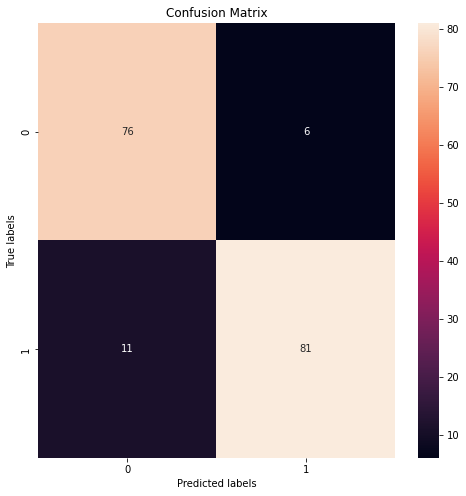

In [28]:
plot_confusion_matrix(y_test, y_preds)

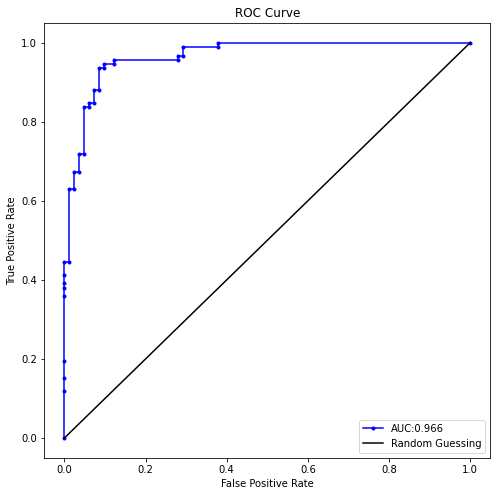

In [29]:
plot_ROC_AUC(y_test, y_probs)

El f1-score obtenido para el conjunto de test es:

In [30]:
f1_score_test = metrics.f1_score(y_test, y_preds)
lstF1.append(f1_score_test)

print("El f1-score obtenido es: " + str(f1_score_test))

El f1-score obtenido es: 0.9050279329608939


## Fold1

### Creación de los vectores labales y features

In [31]:
# Train
X_train = np.array(f1_df_train.iloc[:, 1].to_list())
y_train = np.array(f1_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f1_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f1_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f1_df_test.iloc[:, 1].to_list())
y_test = np.array(f1_df_test.iloc[:, 2].to_list())

### Entrenamiento

In [32]:
early_stopping_model_f1 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [35]:
# # Cargamos el modelo 4
# model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# # Descongelamos todas las capas del modelo 4
# modelf1 = unfreeze_model(model=model_base,
#                         optimizer="sgd",
#                         learning_rate=0.1,
#                         type_model="total")

# Creamos el modelo 5 desde 0, aumento de datos con los pesos de imagenet y todas las capas descongeladas
modelf1 = build_base_model_data_augmentated(optimizer="sgd", learning_rate=0.1, freeze=False)

# Entrenamos el modelo final
start = timer()

history_modelf1 = modelf1.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model_f1],
    verbose=0
)

end = timer()

print("El tiempo de entrenamiento es: " + str(round((end - start) / 60, 2)) + " minutos")

El tiempo de entrenamiento es: 3.2 minutos


### Guardado del modelo

In [39]:
MODEL_NAME = "model_cv_updated/"
EPOCHS = len(history_modelf1.history["val_get_f1"])
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold1/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
modelf1.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold1/model_cv_updated/model_EP20_OPsgd_LR0.1.pickle/assets


In [40]:
# Guardamos el history del modelo
pickle.dump(history_modelf1.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold1/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

In [41]:
y_probs = modelf1.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

In [42]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        91
           1       0.93      0.90      0.91        83

    accuracy                           0.92       174
   macro avg       0.92      0.92      0.92       174
weighted avg       0.92      0.92      0.92       174



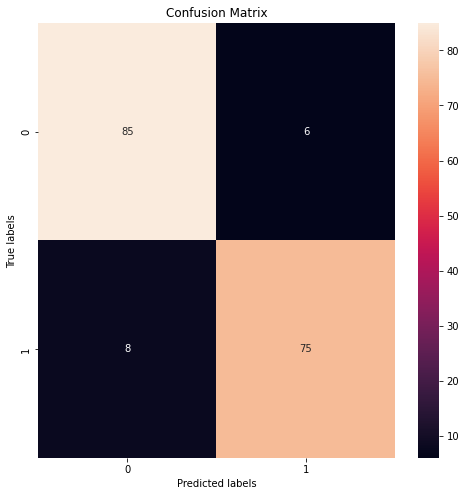

In [43]:
plot_confusion_matrix(y_test, y_preds)

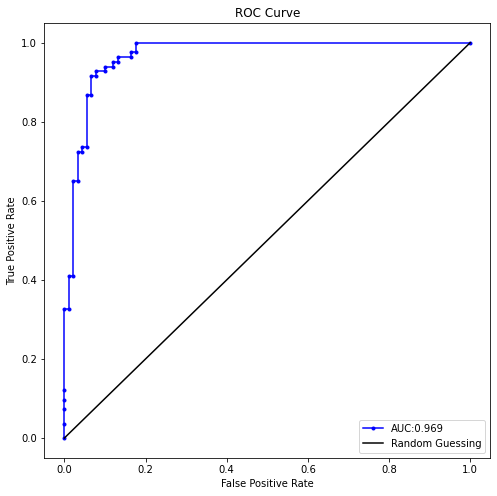

In [44]:
plot_ROC_AUC(y_test, y_probs)

El f1-score obtenido para el conjunto de test es:

In [45]:
f1_score_test = metrics.f1_score(y_test, y_preds)
lstF1.append(f1_score_test)

print("El f1-score obtenido es: " + str(f1_score_test))

El f1-score obtenido es: 0.9146341463414634


## Fold2

### Creación de los vectores labales y features

In [46]:
# Train
X_train = np.array(f2_df_train.iloc[:, 1].to_list())
y_train = np.array(f2_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f2_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f2_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f2_df_test.iloc[:, 1].to_list())
y_test = np.array(f2_df_test.iloc[:, 2].to_list())

### Entrenamiento

In [47]:
early_stopping_model_f2 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [48]:
# # Cargamos el modelo 4
# model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# # Descongelamos todas las capas del modelo 4
# modelf2 = unfreeze_model(model=model_base,
#                         optimizer="sgd",
#                         learning_rate=0.1,
#                         type_model="total")

# Creamos el modelo 5 desde 0, aumento de datos con los pesos de imagenet y todas las capas descongeladas
modelf2 = build_base_model_data_augmentated(optimizer="sgd", learning_rate=0.1, freeze=False)

# Entrenamos el modelo final
start = timer()

history_modelf2 = modelf2.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model_f2],
    verbose=0
)

end = timer()

print("El tiempo de entrenamiento es: " + str(round((end - start) / 60, 2)) + " minutos")

El tiempo de entrenamiento es: 5.3 minutos


### Guardado del modelo

In [50]:
MODEL_NAME = "model_cv_updated/"
EPOCHS = len(history_modelf2.history["val_get_f1"])
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold2/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
modelf2.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold2/model_cv_updated/model_EP34_OPsgd_LR0.1.pickle/assets


In [51]:
# Guardamos el history del modelo
pickle.dump(history_modelf2.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold2/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

In [52]:
y_probs = modelf2.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

In [53]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91        97
           1       0.94      0.82      0.88        77

    accuracy                           0.90       174
   macro avg       0.90      0.89      0.89       174
weighted avg       0.90      0.90      0.90       174



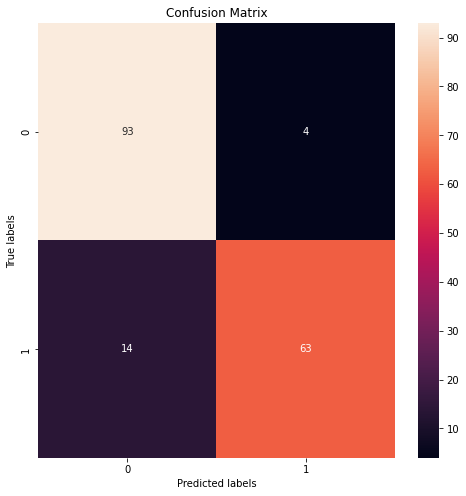

In [54]:
plot_confusion_matrix(y_test, y_preds)

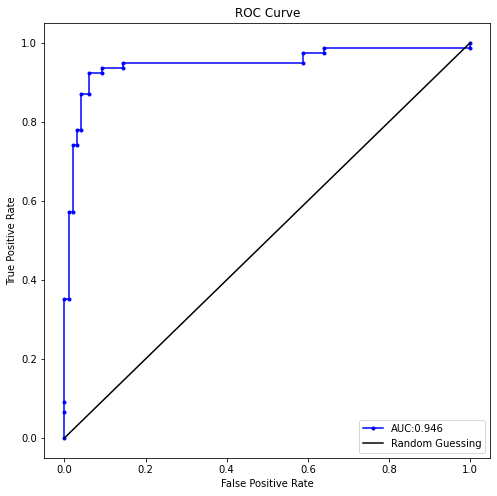

In [55]:
plot_ROC_AUC(y_test, y_probs)

El f1-score obtenido para el conjunto de test es:

In [56]:
f1_score_test = metrics.f1_score(y_test, y_preds)
lstF1.append(f1_score_test)

print("El f1-score obtenido es: " + str(f1_score_test))

El f1-score obtenido es: 0.8750000000000001


## Fold3

### Creación de los vectores labales y features

In [57]:
# Train
X_train = np.array(f3_df_train.iloc[:, 1].to_list())
y_train = np.array(f3_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f3_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f3_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f3_df_test.iloc[:, 1].to_list())
y_test = np.array(f3_df_test.iloc[:, 2].to_list())

### Entrenamiento

In [59]:
early_stopping_model_f3 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [64]:
# # Cargamos el modelo 4
# model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# # Descongelamos todas las capas del modelo 4
# modelf3 = unfreeze_model(model=model_base,
#                         optimizer="sgd",
#                         learning_rate=0.1,
#                         type_model="total")

# Creamos el modelo 5 desde 0, aumento de datos con los pesos de imagenet y todas las capas descongeladas
modelf3 = build_base_model_data_augmentated(optimizer="sgd", learning_rate=0.1, freeze=False)

# Entrenamos el modelo final
start = timer()

history_modelf3 = modelf3.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model_f3],
    verbose=0
)

end = timer()

print("El tiempo de entrenamiento es: " + str(round((end - start) / 60, 2)) + " minutos")

El tiempo de entrenamiento es: 2.28 minutos


### Guardado del modelo

In [67]:
MODEL_NAME = "model_cv_updated/"
EPOCHS = len(history_modelf3.history["val_get_f1"])
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold3/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
modelf3.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold3/model_cv_updated/model_EP14_OPsgd_LR0.1.pickle/assets


In [68]:
# Guardamos el history del modelo
pickle.dump(history_modelf3.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold3/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

In [69]:
y_probs = modelf3.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

In [70]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        91
           1       0.91      0.77      0.84        83

    accuracy                           0.86       174
   macro avg       0.87      0.85      0.85       174
weighted avg       0.86      0.86      0.86       174



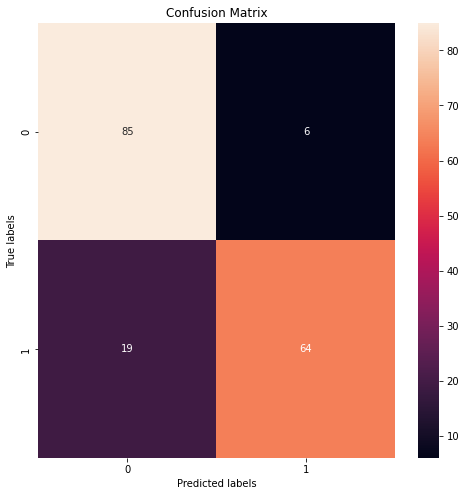

In [71]:
plot_confusion_matrix(y_test, y_preds)

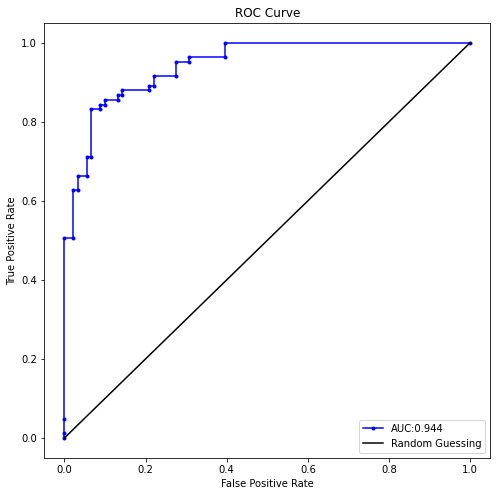

In [72]:
plot_ROC_AUC(y_test, y_probs)

El f1-score obtenido para el conjunto de test es:

In [73]:
f1_score_test = metrics.f1_score(y_test, y_preds)
lstF1.append(f1_score_test)

print("El f1-score obtenido es: " + str(f1_score_test))

El f1-score obtenido es: 0.8366013071895425


## Fold4

### Creación de los vectores labales y features

In [74]:
# Train
X_train = np.array(f4_df_train.iloc[:, 1].to_list())
y_train = np.array(f4_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f4_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f4_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f4_df_test.iloc[:, 1].to_list())
y_test = np.array(f4_df_test.iloc[:, 2].to_list())

### Entrenamiento

In [75]:
early_stopping_model_f4 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [76]:
# # Cargamos el modelo 4
# model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# # Descongelamos todas las capas del modelo 4
# modelf4 = unfreeze_model(model=model_base,
#                         optimizer="sgd",
#                         learning_rate=0.1,
#                         type_model="total")

# Creamos el modelo 5 desde 0, aumento de datos con los pesos de imagenet y todas las capas descongeladas
modelf4 = build_base_model_data_augmentated(optimizer="sgd", learning_rate=0.1, freeze=False)

# Entrenamos el modelo final
start = timer()

history_modelf4 = modelf4.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model_f4],
    verbose=0
)

end = timer()

print("El tiempo de entrenamiento es: " + str(round((end - start) / 60, 2)) + " minutos")

El tiempo de entrenamiento es: 3.62 minutos


### Guardado del modelo

In [79]:
MODEL_NAME = "model_cv_updated/"
EPOCHS = len(history_modelf4.history["val_get_f1"])
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold4/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
modelf4.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold4/model_cv_updated/model_EP23_OPsgd_LR0.1.pickle/assets


In [80]:
# Guardamos el history del modelo
pickle.dump(history_modelf4.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold4/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

In [81]:
y_probs = modelf4.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

In [82]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        92
           1       0.94      0.96      0.95        82

    accuracy                           0.95       174
   macro avg       0.95      0.95      0.95       174
weighted avg       0.95      0.95      0.95       174



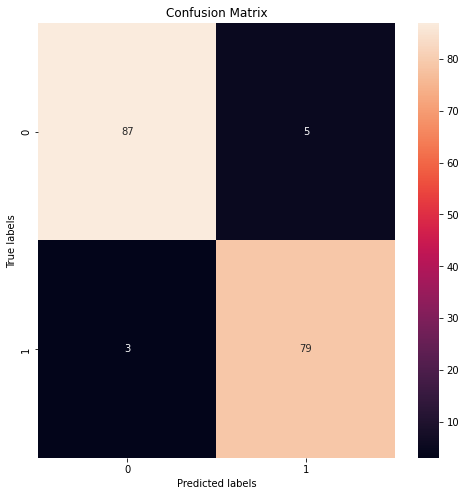

In [83]:
plot_confusion_matrix(y_test, y_preds)

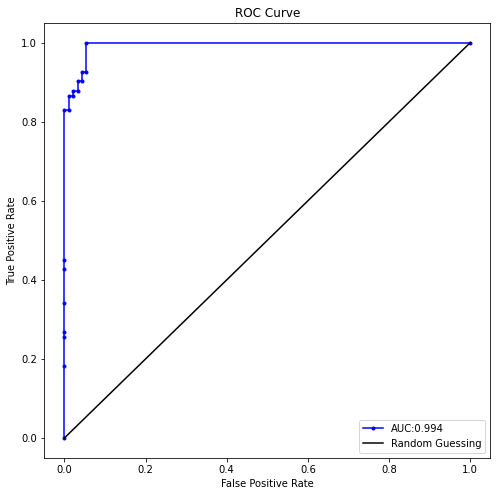

In [84]:
plot_ROC_AUC(y_test, y_probs)

El f1-score obtenido para el conjunto de test es:

In [85]:
f1_score_test = metrics.f1_score(y_test, y_preds)
lstF1.append(f1_score_test)

print("El f1-score obtenido es: " + str(f1_score_test))

El f1-score obtenido es: 0.9518072289156626


## Fold5

### Creación de los vectores labales y features

In [86]:
# Train
X_train = np.array(f5_df_train.iloc[:, 1].to_list())
y_train = np.array(f5_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f5_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f5_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f5_df_test.iloc[:, 1].to_list())
y_test = np.array(f5_df_test.iloc[:, 2].to_list())

### Entrenamiento

In [87]:
early_stopping_model_f5 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [88]:
# # Cargamos el modelo 4
# model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# # Descongelamos todas las capas del modelo 4
# modelf5 = unfreeze_model(model=model_base,
#                         optimizer="sgd",
#                         learning_rate=0.1,
#                         type_model="total")

# Creamos el modelo 5 desde 0, aumento de datos con los pesos de imagenet y todas las capas descongeladas
modelf5 = build_base_model_data_augmentated(optimizer="sgd", learning_rate=0.1, freeze=False)

# Entrenamos el modelo final
start = timer()

history_modelf5 = modelf5.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model_f5],
    verbose=0
)

end = timer()

print("El tiempo de entrenamiento es: " + str(round((end - start) / 60, 2)) + " minutos")

El tiempo de entrenamiento es: 5.32 minutos


### Guardado del modelo

In [91]:
MODEL_NAME = "model_cv_updated/"
EPOCHS = len(history_modelf5.history["val_get_f1"])
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold5/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
modelf5.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold5/model_cv_updated/model_EP34_OPsgd_LR0.1.pickle/assets


In [92]:
# Guardamos el history del modelo
pickle.dump(history_modelf5.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold5/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

In [93]:
y_probs = modelf5.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

In [94]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        90
           1       0.90      0.82      0.86        84

    accuracy                           0.87       174
   macro avg       0.87      0.87      0.87       174
weighted avg       0.87      0.87      0.87       174



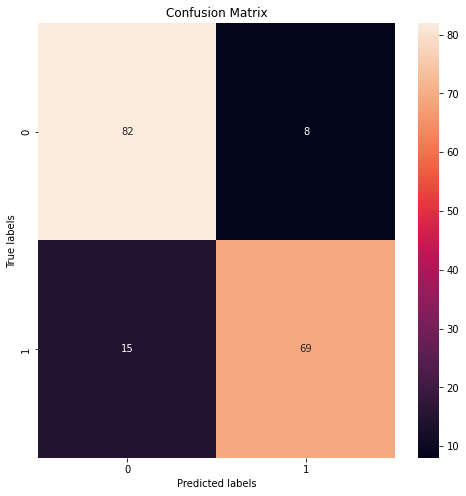

In [95]:
plot_confusion_matrix(y_test, y_preds)

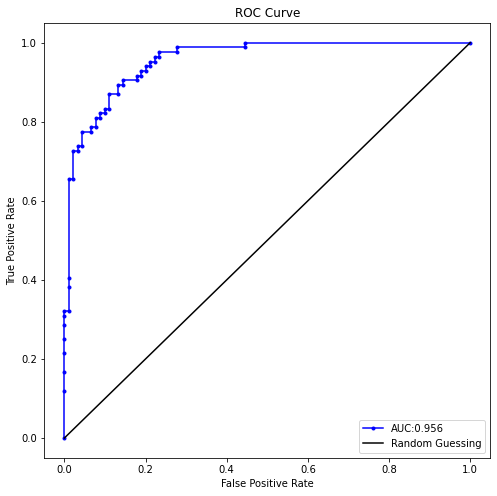

In [96]:
plot_ROC_AUC(y_test, y_probs)

El f1-score obtenido para el conjunto de test es:

In [97]:
f1_score_test = metrics.f1_score(y_test, y_preds)
lstF1.append(f1_score_test)

print("El f1-score obtenido es: " + str(f1_score_test))

El f1-score obtenido es: 0.8571428571428571


## Fold6

### Creación de los vectores labales y features

In [98]:
# Train
X_train = np.array(f6_df_train.iloc[:, 1].to_list())
y_train = np.array(f6_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f6_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f6_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f6_df_test.iloc[:, 1].to_list())
y_test = np.array(f6_df_test.iloc[:, 2].to_list())

### Entrenamiento

In [99]:
early_stopping_model_f6 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [100]:
# # Cargamos el modelo 4
# model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# # Descongelamos todas las capas del modelo 4
# modelf6 = unfreeze_model(model=model_base,
#                         optimizer="sgd",
#                         learning_rate=0.1,
#                         type_model="total")

# Creamos el modelo 5 desde 0, aumento de datos con los pesos de imagenet y todas las capas descongeladas
modelf6 = build_base_model_data_augmentated(optimizer="sgd", learning_rate=0.1, freeze=False)

# Entrenamos el modelo final
start = timer()

history_modelf6 = modelf6.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model_f6],
    verbose=0
)

end = timer()

print("El tiempo de entrenamiento es: " + str(round((end - start) / 60, 2)) + " minutos")

El tiempo de entrenamiento es: 4.07 minutos


### Guardado del modelo

In [103]:
MODEL_NAME = "model_cv_updated/"
EPOCHS = len(history_modelf6.history["val_get_f1"])
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold6/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
modelf6.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold6/model_cv_updated/model_EP26_OPsgd_LR0.1.pickle/assets


In [104]:
# Guardamos el history del modelo
pickle.dump(history_modelf6.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold6/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

In [105]:
y_probs = modelf6.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

In [106]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        81
           1       0.94      0.87      0.91        93

    accuracy                           0.90       174
   macro avg       0.90      0.90      0.90       174
weighted avg       0.91      0.90      0.90       174



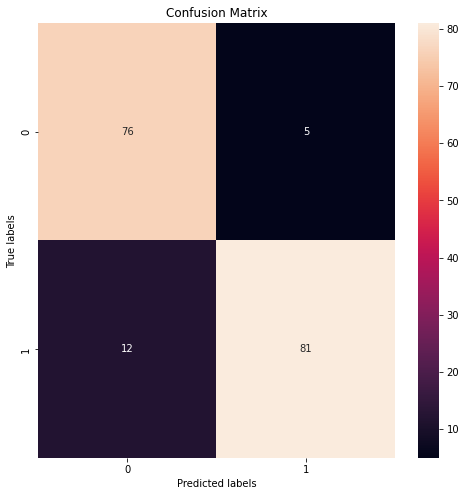

In [107]:
plot_confusion_matrix(y_test, y_preds)

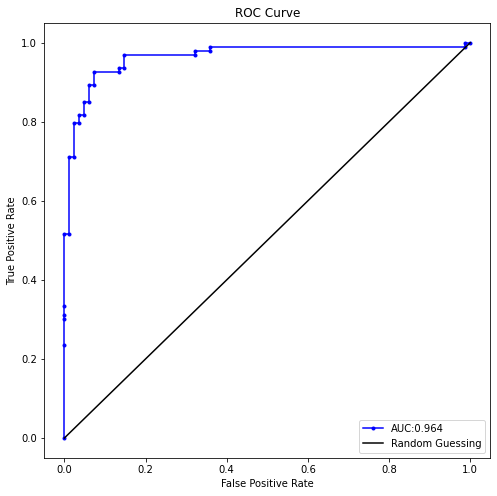

In [108]:
plot_ROC_AUC(y_test, y_probs)

El f1-score obtenido para el conjunto de test es:

In [109]:
f1_score_test = metrics.f1_score(y_test, y_preds)
lstF1.append(f1_score_test)

print("El f1-score obtenido es: " + str(f1_score_test))

El f1-score obtenido es: 0.9050279329608939


## Fold7

### Creación de los vectores labales y features

In [110]:
# Train
X_train = np.array(f7_df_train.iloc[:, 1].to_list())
y_train = np.array(f7_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f7_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f7_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f7_df_test.iloc[:, 1].to_list())
y_test = np.array(f7_df_test.iloc[:, 2].to_list())

### Entrenamiento

In [111]:
early_stopping_model_f7 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [112]:
# # Cargamos el modelo 4
# model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# # Descongelamos todas las capas del modelo 4
# modelf7 = unfreeze_model(model=model_base,
#                         optimizer="sgd",
#                         learning_rate=0.1,
#                         type_model="total")

# Creamos el modelo 5 desde 0, aumento de datos con los pesos de imagenet y todas las capas descongeladas
modelf7 = build_base_model_data_augmentated(optimizer="sgd", learning_rate=0.1, freeze=False)

# Entrenamos el modelo final
start = timer()

history_modelf7 = modelf7.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model_f7],
    verbose=0
)

end = timer()

print("El tiempo de entrenamiento es: " + str(round((end - start) / 60, 2)) + " minutos")

El tiempo de entrenamiento es: 3.52 minutos


### Guardado del modelo

In [115]:
MODEL_NAME = "model_cv_updated/"
EPOCHS = len(history_modelf7.history["val_get_f1"])
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold7/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
modelf7.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold7/model_cv_updated/model_EP22_OPsgd_LR0.1.pickle/assets


In [116]:
# Guardamos el history del modelo
pickle.dump(history_modelf7.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold7/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

In [117]:
y_probs = modelf7.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

In [118]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       100
           1       0.94      0.84      0.89        74

    accuracy                           0.91       174
   macro avg       0.91      0.90      0.90       174
weighted avg       0.91      0.91      0.91       174



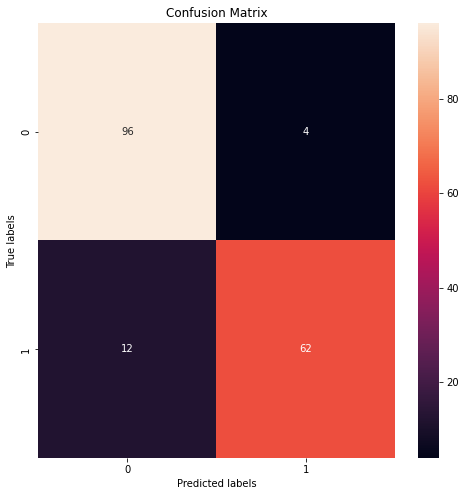

In [119]:
plot_confusion_matrix(y_test, y_preds)

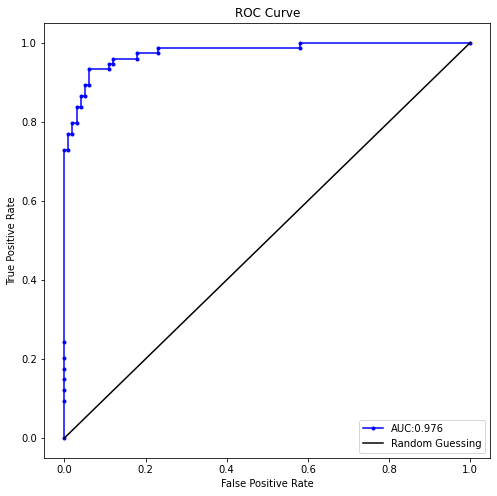

In [120]:
plot_ROC_AUC(y_test, y_probs)

El f1-score obtenido para el conjunto de test es:

In [121]:
f1_score_test = metrics.f1_score(y_test, y_preds)
lstF1.append(f1_score_test)

print("El f1-score obtenido es: " + str(f1_score_test))

El f1-score obtenido es: 0.8857142857142858


## Fold8

### Creación de los vectores labales y features

In [122]:
# Train
X_train = np.array(f8_df_train.iloc[:, 1].to_list())
y_train = np.array(f8_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f8_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f8_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f8_df_test.iloc[:, 1].to_list())
y_test = np.array(f8_df_test.iloc[:, 2].to_list())

### Entrenamiento

In [123]:
early_stopping_model_f8 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [124]:
# # Cargamos el modelo 4
# model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# # Descongelamos todas las capas del modelo 4
# modelf8 = unfreeze_model(model=model_base,
#                         optimizer="sgd",
#                         learning_rate=0.1,
#                         type_model="total")

# Creamos el modelo 5 desde 0, aumento de datos con los pesos de imagenet y todas las capas descongeladas
modelf8 = build_base_model_data_augmentated(optimizer="sgd", learning_rate=0.1, freeze=False)

# Entrenamos el modelo final
start = timer()

history_modelf8 = modelf8.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model_f8],
    verbose=0
)

end = timer()

print("El tiempo de entrenamiento es: " + str(round((end - start) / 60, 2)) + " minutos")

El tiempo de entrenamiento es: 5.33 minutos


### Guardado del modelo

In [127]:
MODEL_NAME = "model_cv_updated/"
EPOCHS = len(history_modelf8.history["val_get_f1"])
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold8/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
modelf8.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold8/model_cv_updated/model_EP34_OPsgd_LR0.1.pickle/assets


In [128]:
# Guardamos el history del modelo
pickle.dump(history_modelf8.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold8/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

In [129]:
y_probs = modelf8.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

In [130]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87        91
           1       0.89      0.81      0.85        83

    accuracy                           0.86       174
   macro avg       0.87      0.86      0.86       174
weighted avg       0.86      0.86      0.86       174



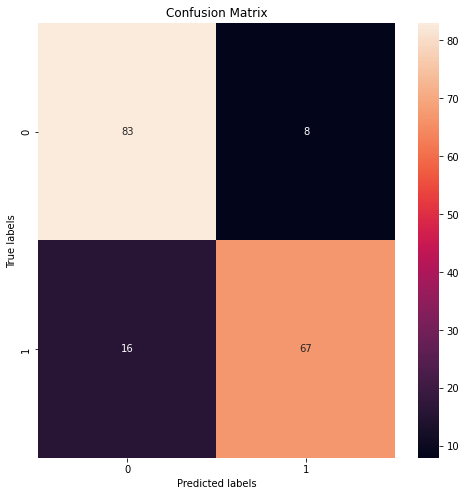

In [131]:
plot_confusion_matrix(y_test, y_preds)

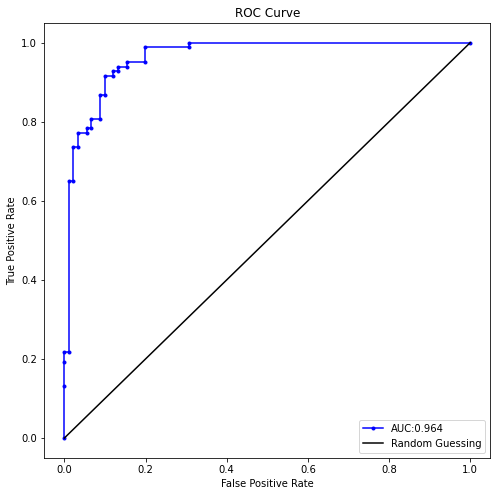

In [132]:
plot_ROC_AUC(y_test, y_probs)

El f1-score obtenido para el conjunto de test es:

In [133]:
f1_score_test = metrics.f1_score(y_test, y_preds)
lstF1.append(f1_score_test)

print("El f1-score obtenido es: " + str(f1_score_test))

El f1-score obtenido es: 0.8481012658227848


## Fold9

### Creación de los vectores labales y features

In [134]:
# Train
X_train = np.array(f9_df_train.iloc[:, 1].to_list())
y_train = np.array(f9_df_train.iloc[:, 2].to_list())
# Valid
X_valid = np.array(f9_df_valid.iloc[:, 1].to_list())
y_valid = np.array(f9_df_valid.iloc[:, 2].to_list())
# # Test
X_test = np.array(f9_df_test.iloc[:, 1].to_list())
y_test = np.array(f9_df_test.iloc[:, 2].to_list())

### Entrenamiento

In [135]:
early_stopping_model_f9 = EarlyStopping(monitor="val_get_f1", mode="max", patience=5)

In [136]:
# # Cargamos el modelo 4
# model_base = load_model("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold0/model4/model_EP21_OPadam_LR0.0001.pickle", custom_objects={"get_f1": get_f1})

# # Descongelamos todas las capas del modelo 4
# modelf9 = unfreeze_model(model=model_base,
#                         optimizer="sgd",
#                         learning_rate=0.1,
#                         type_model="total")

# Creamos el modelo 5 desde 0, aumento de datos con los pesos de imagenet y todas las capas descongeladas
modelf9 = build_base_model_data_augmentated(optimizer="sgd", learning_rate=0.1, freeze=False)

# Entrenamos el modelo final
start = timer()

history_modelf9 = modelf9.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping_model_f9],
    verbose=0
)

end = timer()

print("El tiempo de entrenamiento es: " + str(round((end - start) / 60, 2)) + " minutos")

El tiempo de entrenamiento es: 3.96 minutos


### Guardado del modelo

In [139]:
MODEL_NAME = "model_cv_updated/"
EPOCHS = len(history_modelf9.history["val_get_f1"])
OPTIMIZER = "sgd"
LEARNING_RATE = 0.1

# Guardamos el modelo
model_save_path = "/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold9/" + MODEL_NAME + "model_" + "EP" + str(EPOCHS) + "_" + "OP" + OPTIMIZER  + "_" + "LR" + str(LEARNING_RATE) + '.pickle'
modelf9.save(model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/practica_DL_UOC_2022/models/Fold9/model_cv_updated/model_EP25_OPsgd_LR0.1.pickle/assets


In [140]:
# Guardamos el history del modelo
pickle.dump(history_modelf9.history, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/Fold9/" + MODEL_NAME, "history.pickle"), 'wb'))

### Evaluación del modelo

In [141]:
y_probs = modelf9.predict(X_test)
y_preds = []

# Cálculo de la salida de la red
for y_prob in y_probs:
  if y_prob < 0.5:
    y_preds.append(0)
  else:
    y_preds.append(1)

In [142]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       104
           1       0.93      0.80      0.86        70

    accuracy                           0.90       174
   macro avg       0.91      0.88      0.89       174
weighted avg       0.90      0.90      0.89       174



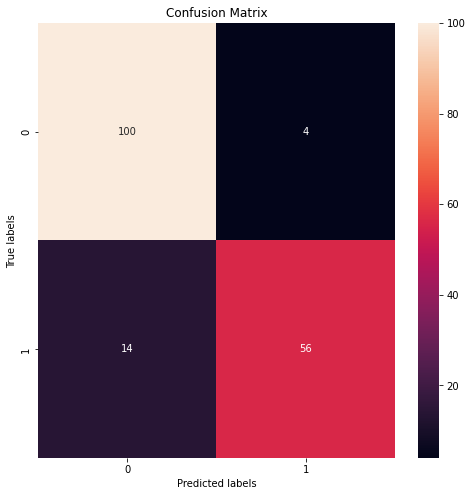

In [143]:
plot_confusion_matrix(y_test, y_preds)

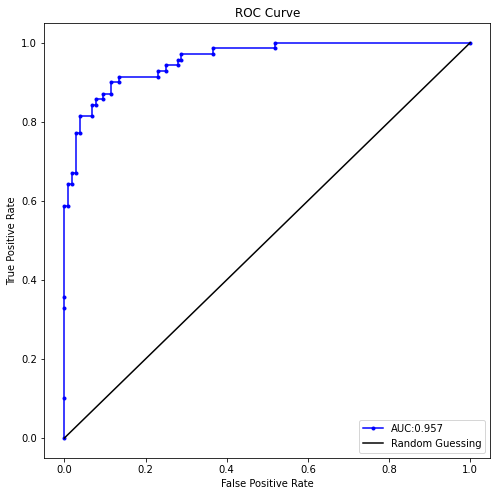

In [144]:
plot_ROC_AUC(y_test, y_probs)

El f1-score obtenido para el conjunto de test es:

In [145]:
f1_score_test = metrics.f1_score(y_test, y_preds)
lstF1.append(f1_score_test)

print("El f1-score obtenido es: " + str(f1_score_test))

El f1-score obtenido es: 0.8615384615384616


## Guardado de los f1-score

In [146]:
# Guardamos todos los f1-score obtenidos
pickle.dump(lstF1, open(os.path.join("/content/drive/MyDrive/practica_DL_UOC_2022/models/f1-scores-updated.pickle"), 'wb'))

## Resultados de cross validation

El valor medio y la desviación estándar de los f1-score obtenidos son:

In [147]:
print("El valor f1-score medio obtenido es: " + str(round(np.mean(lstF1), 2)))
print("La desviación estándar obtenida es: " + str(round(np.std(lstF1), 2)))

El valor f1-score medio obtenido es: 0.88
La desviación estándar obtenida es: 0.03


##Discusión de los resultados

Cabe recordar que el modelo usado para realizar esta sección es el modelo 5, es decir, hacer uso de los pesos de imagenet, un aumento de datos y un fine-tuning descongelando toda la red.

Como podemos apreciar en la anterior ejecución, el f1-score medio obtenido para los 10 folds es elevado para el conjunto de test, además, la desviación estándar es baja, por lo que los resultados que se pueden conseguir con este modelo son muy buenos independientemente del conjunto de datos.

Por otro lado, el glaucoma es una patología muy grave, por lo que es importante reducir los falsos negativos del modelo. Plantenado la siguiente pregunta que se establece en la práctica: `¿Qué estrategia seguirías pra conseguir este propósito y qué penalizaciones podría tener esta decisión?`

Hay varias formas de reducir los falsos negativos que tiene un modelo:

1/ Encontrando los hiperparámetros idóneos, este punto ya se ha realizado en la anterior sección de esta práctica, pero de todas formas se podrían realizar más pruebas con el objetivo de afinar aún más los hiperparámetros.

2/ Cambiar el discriminador entre un caso positivo y un caso negativo, ahora mismo cuando se introduce una imagen a la red neuronal ésta nos devuelve una probabilidad. Si es inferior a 0.5 se considera que es un caso negativo y si es superior a 0.5 estamos en un caso positivo. Cambiar el discriminador, es decir, el 0.5 nos permitiría ajustar mejor el modelo buscando reducir los falsos negativos, si el discriminador es 0.4 se detectarían más positivos (incluyendo los falsos negativos). Puede haber casos que la red nos devuelva un 0.45 pero realmente sí que es un caso positivo, por lo tanto cambiando el dicriminadorr se podría mejorar. El punto negativo de esto es que a ciencia cierta es díficil dar un valor perfecto, siempre se va a haber falsos positivos y falsos negativos.

3/ Mejorar el dataset haciendo que haya más datos y por lo tanto más variabilidad con la que pueda entrenar la red. Este punto también lo hemos conseguido haciendo un aumento de datos, de esta forma "creamos" nuevas imágenes con las que es capaz de aprender y mejorar la red, de esta forma se reducen también los falsos negativos como se ha visto en las matrices de confusión correspondientes en la sección 2.

4/ Hay datos desbalanceadoios, es decir, a la red no se la entrena con el mismo número de imágenes para casos positivos que para casos negativos. En este caso, tenemos dos soluciones posibles;

* Hacer un amento de datos de la clase minoritaria.
* Indicar a la red neuronal qué la clase es más importante y para ello podemos hacer uso del atributo `clasas_weight` en el ajuste del modelo, indicando así que la clase positiva es más importante. El principal inconveniente que tiene es que podría aumentar los falsos positivos, haciendo así que la precisión general del modelo sea peor.


# Sección 4 - Análisis crítico

Contesta, de forma razonada y justificada, a las siguientes preguntas:

a) Para la realización de la práctica se han entregado las folds preparadas para el entrenamiento.

* Indicar qué estrategia de diseño hubieras seguido si las hubieras tenido que definir tú.

* Indicar qué puntos son importantes en el diseño de estas particiones para que los modelos resultantes tengan una buena capacidad de generalización.

b) Realizar un análisis crítico de los resultados  obtenidos y las conclusiones a las que has llegado después de realizar esta práctica.


Respondiendo a la pregunta del apartado a), la estrategia de diseño que hubiera seguido sería diferente.

Un problema fundamental que tienen estas particiones es que no siempre hay el mismo número de imágenes con casos positivos que negativos, dicho en otras palabras no se sigue la misma distribución de valores.

Al suceder esto se pudean estar creando modelos sesgados a favor de la clase mayoritaria que hay en cada conjunto de entrenamiento para cada fold.

Por lo tanto, esto lo podemos resolver de dos formas:

* Haciendo que la partición aleatoria de los datos tenga en cuenta la distribución de los casos, es decir, que sea similar en cada fold el número de casos positivos y el número de casos negativos.

* La segunda forma es realizando un aumento de datos sobre la clase minoritaria, así se consigue que para todos los conjuntos de entrenamiento haya el mismo número de casos positivos que negativos.

Tendiendo en cuenta que es importante la distribución de valores para una buena generalización, en mi caso hubiera hecho una primera partición aleatoria, y a partir de este crear k particiones con distribuiones en el número de casos similar. Consiguiendo así reducir el sesgo y mejorar la capacidad de generalización del modelo.

Respondiendo a la pregunta del apartado b), se detalla a continuación los resultados obtenidos y las conclusiones del proyecto.

* En primer lugar se ha definido el modelo 1, el cual se caracterizaba porque hacía uso de EfficientNetB0. En este caso, solo se entrenaba el clasificador final, haciendo que el resto de capas estuvieran congeladas. Tras hacer una búsqueda intensiva de los hiperparámetros idóneos, se llegó a la conclusión que el modelo que mejor funcinaba presentaba un optimizador SGD y un learning rate de 0.001.

  Los resultados obtenidos con ese modelo son buenos, se conseguía una elevada precisión para los casos en los que había una anomalía, pero la sensibilidad de los casos postivios era baja. El f1-score obtenido para la clase negativa era de 0.83 y para la positiva de 0.82. No es un mal modelo, pero lo idóneo es que el f1-score sea igual o superior a 0.9.

  Por otro lado, estamos en un problema del ámbito sanitario, por lo que el objetivo es reducir los falsos negativos. En este modelo había 8 falsos positivos para el conjunt ode test y 23 falsos negativos. Por lo que no termina de resolver de forma adecuada la problemática que se plantea.

* El siguiente modelo era el 2, y se basaba en el modelo 1 con la excpeción de que se descongelaban las últimas 20 capas del modelo base. Los hiperparámetros adecuados para este modleo han sido optimizador ADAM y un learning rate de 0.0001.

  Los resultados obtenidos para este modelo han sido similares al modelo anterior en cuantoa la detección de no anomalías. En el caso de que la imágen sea un ojo con glaucoma el modelo consigue una mayor precisión pero un menor recall respecto al modelo 1, es decir, se consigue reducir los falsos postivos pero no los falsos negativos.

  En este caso, el f1-score obtenido para la clase sin anomalía es de 0.83 y de 0.81 en los casos que sí que hay anomalía. En resumen, a nivel númerico se comporta mejor este modelo que el anterior, pero estamos en el ámbito sanitatio, por lo que hay que priorizar los falsos negativos en vez de lso falsos postivos, debido a esto este modelo no ha sido capaz de superar al anterior.

* El siguiente modelo fue el 3, basándose en los dos anteriores modelo pero descongelando toda la red. Los hiperparámetros adecuados fueron el optimizador SGD y un learning rate de 0.1.

  Tras entrenar la red, se han obtenido muy buenos resultados, mejores que los anteriores, tanto a nivel numérico como teniendo en cuenta que estamos en el ámbito sanitario.

  En este caso, se consigue una mayor precisión y recall para ambas clases, haciendo que el f1-score sea superior, para la clase 0 se obtiene un 0.87 y para la clase 1 un 0.86.

  Al aumentar la precisión se consigue reducir los falsos positivos, pero al aumentar también la sensibilidad se consigue reducir los falsos negativos.

  Por lo tanto, las conclusiones que obtenemos en este apartado es que al descongelar un mayor número de capas del modelo base, el modelo es capaz de aprender mejor los datos y mejarar las salidad que proporciona el mismo.

* El siguiente modelo creado fue el 4, es similar al modelo 2 pero en este caso se añade una capa de aumento de datos. Los hipeparámetros usados han sido un optimizador ADAM y un learning rate de 0.0001.

  Comparando este modelo respecto al modelo 2 se ha conseguido mejorar los resultados a partir del aumento de datos. En este caso, hay mejoras tanto en la precisión como en el recall consiguiendo así aumentar el f1-score, para la clase 0 de 0.85 y para la clase 1 de 0.84.

  Aspecto a tener en cuenta es que se consigue reducir los falsos negativos.

  En resumen, este modelo comparando con el modelo 2 se comporta mejor, pero aún así es algo pero que el modelo3.

* El último modelo ha sido el 5, en él se hace lo mismo que en el modelo 3 pero realizando también un aumento de datos. Los hiperparámetros idóneos han sido un optmizador SGD y un learning rate de 0.1.

  Los resultados obtenidos para este modelo han sido los mejores encontrados. Se mejora la precisión, el recall y por lo tanto el f1-score. En este caso para ambas clases el f1-score es de 0.9, haciendo que este modelo sí que sea muy bueno.

  Otro aspecto a tener en cuenta es que este modelo es el que consigue reducir más los falsos negativos.

  Las conclusiones obtenidas respecto a este modelo y al anterior es que al hacer un aumento de datos, y descongelar parcialmente o totalmente la red, se consigue mejorar de forma considerable el modelo.

* En cuanto a la sección 3, se ha hecho uso del modelo 5 para realizar la validación cruzada.

  En este caso se ha obtenido un f1-score medio de 0.88 para los 10 folds con una desviación estándar de 0.03.

  Como podemos apreciar, el f1-score medio es elevado para el conjunto de test, y la desviación estándar es baja, haciendo que los resultados obtenidos sean muy buenos independientemente de el conjunto de datos utilizado.

  Por lo que llegamos a la conclusión de que el modelo 5 es el mejor, básicamente por hacer uso de una red pre-entrenada EfficientNetB0, hacer un aumento de datos y descongelar totalmente la red. Por lo tanto, todo esto influye considerablemente en obtener un alto rendimiento del modelo.